#פיתוח מודל לחיזוי סיכויי העזיבה של עובדים במוקדי שירות טלפוניים בישראל

# Project Notebook: Survival Analysis (Cox Regression) for Employee Attrition Prediction in Call Centers

# **הרצת התפלגות עבור כלל המשתנים**

In [1]:
#[1]
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# קריאת הקובץ
file_path = "/content/DATA.xlsx"
df = pd.read_excel(file_path, sheet_name="data")

# משתנה סטטוס
status_col = "status"   # 0=Active, 1=Resigned
TENURE_COL = "time_in_company"

# תיקיית פלט
OUT_DIR = Path("/content/eda_charts")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# צבעים קבועים (Active=תכלת, Resigned=ורוד)
status_colors = {0: 'skyblue', 1: 'salmon'}

# ------------------------
# רשימת משתנים שהם קטגוריאליים "לוגית"
forced_categorical = [
    "resignation_year",
    "resignation_month",
    "resignation_reason",
    'avg_annual_vacation_increase',
    'avg_annual_sick_increase',
    "family_status",
    'gender',
    "children",
    "call_center",
    "Team_size"
]

# קביעת משתנים לפי לוגיקה
categorical_vars = [c for c in df.columns if c in forced_categorical]
continuous_vars = [c for c in df.columns if c not in categorical_vars + [status_col]]

# ---------- 1) משתנים רציפים ----------
for col in continuous_vars:
    plt.figure(figsize=(8,4))
    for s in [0,1]:
        sns.kdeplot(
            df.loc[df[status_col]==s, col].dropna(),
            label=f"{'Active' if s==0 else 'Resigned'} ({s})",
            color=status_colors[s],
            fill=True,
            alpha=0.5
        )
    plt.title(f"Distribution of {col} by Employee Status")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{col}_distribution.png")
    plt.close()

# ---------- 2) משתנים קטגוריאליים ----------
for col in categorical_vars:
    plt.figure(figsize=(8,4))
    ax = sns.countplot(
        data=df, x=col, hue=status_col,
        palette=[status_colors[0], status_colors[1]],
        dodge=True
    )
    ax.set_title(f"Distribution of {col} by Employee Status")
    ax.set_xlabel(f"{col} (coded values)")
    ax.set_ylabel("Number of Employees")
    plt.xticks(rotation=30, ha="right")

    # הוספת ערכים מעל כל עמודה
    for p in ax.patches:
        height = int(p.get_height())
        if height > 0:
            ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=9, color='black', rotation=0)

    plt.legend(title="Status", labels=["Active (0)", "Resigned (1)"])
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{col}_distribution.png")
    plt.close()

print(f"✓ גרפים נשמרו בתיקייה: {OUT_DIR}")


✓ גרפים נשמרו בתיקייה: /content/eda_charts


In [2]:
#[2]
import pandas as pd
from pandas.api.types import (
    is_numeric_dtype, is_datetime64_any_dtype,
    is_categorical_dtype, is_string_dtype, is_bool_dtype
)

def summarize_ranges(df: pd.DataFrame, top_levels: int = 5) -> pd.DataFrame:
    rows = []
    for col in df.columns:
        x = df[col]
        dtype = str(x.dtype)
        n_total = len(x)
        n_missing = int(x.isna().sum())
        n_unique = int(x.nunique(dropna=True))

        if is_numeric_dtype(x):
            min_val = x.min(skipna=True)
            max_val = x.max(skipna=True)
            range_width = (max_val - min_val) if pd.notna(min_val) and pd.notna(max_val) else pd.NA
            rows.append({
                'variable': col, 'dtype': dtype,
                'n_missing': n_missing, 'n_unique': n_unique,
                'min': min_val, 'max': max_val, 'range_width': range_width,
                'example_levels': pd.NA
            })
        elif is_datetime64_any_dtype(x):
            min_val = x.min(skipna=True)
            max_val = x.max(skipna=True)
            rows.append({
                'variable': col, 'dtype': dtype,
                'n_missing': n_missing, 'n_unique': n_unique,
                'min': str(min_val) if pd.notna(min_val) else pd.NA,
                'max': str(max_val) if pd.notna(max_val) else pd.NA,
                'range_width': pd.NA, 'example_levels': pd.NA
            })
        else:
            # קטגוריאלי/מחרוזת/בוליאני – אין "טווח", נציג רמות
            vals = x.dropna().astype(str).unique()
            example = ", ".join(sorted(vals)[:top_levels]) if len(vals) > 0 else ""
            rows.append({
                'variable': col, 'dtype': dtype,
                'n_missing': n_missing, 'n_unique': n_unique,
                'min': pd.NA, 'max': pd.NA, 'range_width': pd.NA,
                'example_levels': example
            })
    return pd.DataFrame(rows).sort_values('variable').reset_index(drop=True)

ranges_all = summarize_ranges(df, top_levels=5)
ranges_all


,variable,dtype,n_missing,n_unique,min,max,range_width,example_levels
0,Team_size,int64,0,5,1.000000,5.000000,4.000000,<NA>
1,age,int64,0,40,17.000000,61.000000,44.000000,<NA>
2,answered_calls_center_avg,float64,462,7,238.473627,648.606518,410.132891,<NA>
3,answered_calls_employee_avg,float64,462,1265,27.000000,1358.000000,1331.000000,<NA>
4,answered_calls_employee_avg_3month,float64,462,1187,1.000000,1581.666667,1580.666667,<NA>
5,avg_annual_sick_increase,int64,0,2,0.000000,1.000000,1.000000,<NA>
6,avg_annual_vacation_increase,int64,0,2,0.000000,1.000000,1.000000,<NA>
7,bonus_avg,float64,0,1496,0.000000,5780.630000,5780.630000,<NA>
8,call_center,int64,0,7,1.000000,7.000000,6.000000,<NA>
9,call_duration_center_avg,float64,462,7,6.167656,428.641919,422.474263,<NA>


# **טעינת ספריות וקבצים ועיבוד סטטיסטי ראשוני**

In [3]:
# [4]
!pip -q install lifelines statsmodels plotly openpyxl scikit-learn
import warnings; warnings.filterwarnings("ignore")

# טעינת ספריות
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import proportional_hazard_test
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

# הגדרות גרפיות
plt.rcParams['font.family'] = 'Arial'
sns.set(style="whitegrid")

# הגדרות קובץ ועמודות מרכזיות
file_path = "/content/DATA.xlsx"
TENURE_COL = 'time_in_company'
EVENT_COL = 'status'
ID_COL = 'id'

# קריאת הנתונים
df = pd.read_excel(file_path)

# מידע כללי
print("מידע כללי:")
df.info()  # ← הצגה נכונה של info()

# סטטיסטיקות תיאוריות
print("\n סטטיסטיקות תיאוריות:")
display(df.describe(include='all'))

# ערכים חסרים
print("\n מספר ערכים חסרים בכל עמודה:")
missing_summary = df.isnull().sum().to_frame(name='Missing_Values')
missing_summary['% Missing'] = 100 * missing_summary['Missing_Values'] / len(df)
missing_summary = missing_summary[missing_summary['Missing_Values'] > 0]
display(missing_summary.sort_values(by='Missing_Values', ascending=False))

# שונות של משתנים מספריים
print("\n עמודות עם שונות נמוכה (variance < 0.01):")
numeric_df = df.select_dtypes(include=[np.number])
variances = numeric_df.var().sort_values()
low_variance = variances[variances < 0.01]
display(low_variance)


מידע כללי:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  1751 non-null   int64  
 1   status                              1751 non-null   int64  
 2   gender                              1751 non-null   int64  
 3   age                                 1751 non-null   int64  
 4   time_in_company                     1751 non-null   float64
 5   salary_per_hour                     1751 non-null   float64
 6   children                            1751 non-null   int64  
 7   call_center                         1751 non-null   int64  
 8   resignation_year                    1339 non-null   float64
 9   resignation_month                   1339 non-null   float64
 10  resignation_reason                  1339 non-null   float64
 11  family_status                   

,id,status,gender,age,time_in_company,salary_per_hour,children,call_center,resignation_year,resignation_month,...,calls_perhour_employee_avg_3month,pause_center_employee_avg_3month,answered_calls_employee_avg,call_duration_employee_avg,calls_perhour_employee_avg,pause_center_employee_avg,answered_calls_center_avg,call_duration_center_avg,calls_perhour_center_avg,pause_center_avg
count,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.00000,1339.000000,1339.000000,...,1289.000000,1289.000000,1289.000000,1289.000000,1289.000000,1289.000000,1289.000000,1289.000000,1289.000000,1289.000000
mean,935.478584,0.764706,0.872644,28.106225,17.429697,30.808932,0.232439,4.88064,2021.105302,5.893204,...,251.647513,0.104060,487.054593,250.039622,271.464259,0.101465,511.183293,240.777276,214.232382,0.101233
std,519.404500,0.424304,0.333466,5.503155,21.722770,1.888561,0.422508,1.88438,2.158543,3.308923,...,374.621272,0.024571,204.620559,226.190289,383.024879,0.019141,136.225828,182.613222,271.899094,0.005823
min,1.000000,0.000000,0.000000,17.000000,3.000000,28.490000,0.000000,1.00000,2017.000000,0.000000,...,1.000000,0.000000,27.000000,1.045959,1.000000,0.000000,238.473627,6.167656,6.773708,0.087417
25%,503.500000,1.000000,1.000000,24.000000,6.066667,29.120000,0.000000,3.00000,2019.000000,3.000000,...,6.858042,0.093684,324.154313,9.900751,6.552478,0.093390,362.430722,8.446827,7.452316,0.095773
50%,944.000000,1.000000,1.000000,27.000000,11.200000,30.610000,0.000000,5.00000,2021.000000,6.000000,...,8.734123,0.102858,452.004859,330.201507,8.271026,0.100690,610.129584,351.050873,7.991478,0.102099
75%,1382.500000,1.000000,1.000000,31.000000,21.000000,32.300000,0.000000,7.00000,2023.000000,9.000000,...,492.666667,0.113524,617.333333,404.152686,591.888889,0.109080,633.161429,396.293095,510.328571,0.105331
max,1822.000000,1.000000,1.000000,61.000000,274.133333,44.920000,1.000000,7.00000,2024.000000,11.000000,...,1948.000000,0.539485,1358.000000,4245.774025,1869.333333,0.539485,648.606518,428.641919,773.670273,0.107413



 מספר ערכים חסרים בכל עמודה:


,Missing_Values,% Missing
calls_perhour_employee_avg_3month,462,26.384923
call_duration_employee_avg_3month,462,26.384923
answered_calls_employee_avg_3month,462,26.384923
pause_center_employee_avg_3month,462,26.384923
calls_perhour_employee_avg,462,26.384923
call_duration_employee_avg,462,26.384923
answered_calls_employee_avg,462,26.384923
answered_calls_center_avg,462,26.384923
call_duration_center_avg,462,26.384923
calls_perhour_center_avg,462,26.384923



 עמודות עם שונות נמוכה (variance < 0.01):


,0
pause_center_avg,0.000034
pause_center_employee_avg,0.000366
pause_center_employee_avg_3month,0.000604


# **מה המשתנים שמשפיעים על עזיבה - תחקיר ראשוני**

בדיקת איזון בדאטה - ניתן לראות חוסר איזון

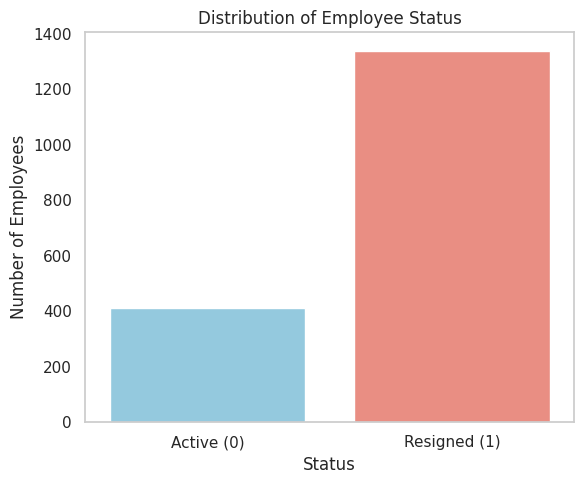

In [4]:
# [5]
status_counts = df['status'].value_counts().sort_index()
status_labels = ['Active (0)', 'Resigned (1)']

plt.figure(figsize=(6, 5))
sns.barplot(x=status_labels, y=status_counts.values, palette=['skyblue', 'salmon'])
plt.title("Distribution of Employee Status")
plt.ylabel("Number of Employees")
plt.xlabel("Status")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


התפלגות של וותק בארגון – עובדים פעילים אל מול עובדים שעזבו

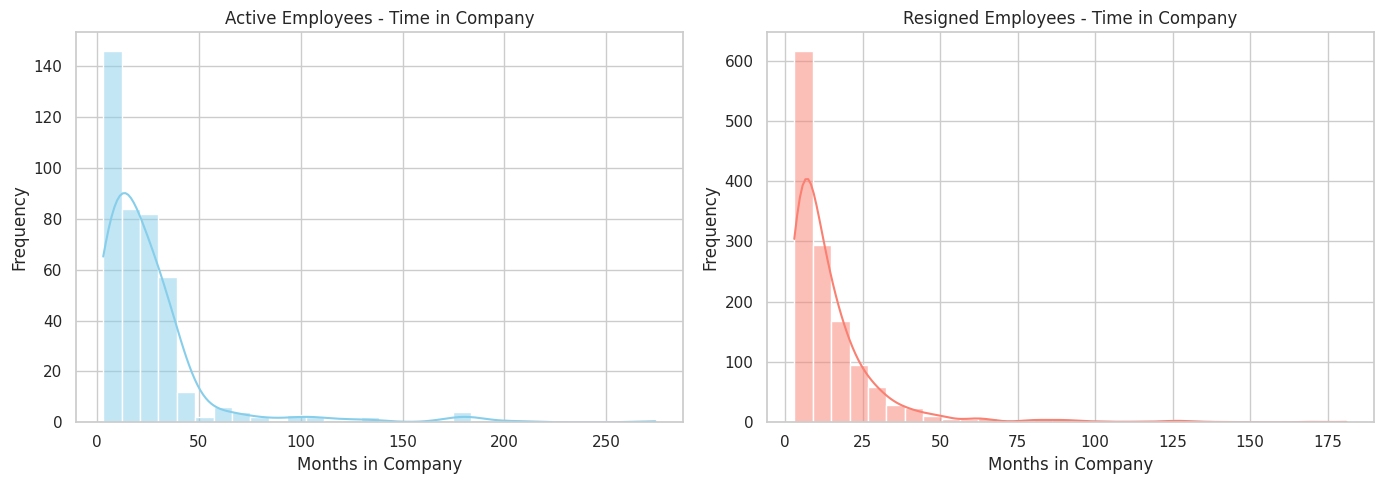

In [5]:
# [6]
# פיצול לפי סטטוס
active = df[df['status'] == 0]
resigned = df[df['status'] == 1]

# ציור שני גרפים זה לצד זה
plt.figure(figsize=(14, 5))

# גרף עבור עובדים פעילים
plt.subplot(1, 2, 1)
sns.histplot(active['time_in_company'], bins=30, kde=True, color='skyblue')
plt.title('Active Employees - Time in Company')
plt.xlabel('Months in Company')
plt.ylabel('Frequency')

# גרף עבור עובדים שעזבו
plt.subplot(1, 2, 2)
sns.histplot(resigned['time_in_company'], bins=30, kde=True, color='salmon')
plt.title('Resigned Employees - Time in Company')
plt.xlabel('Months in Company')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


הגדרות בסיס

In [6]:
# [7]
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from scipy.stats import mannwhitneyu

TENURE_COL = 'time_in_company'   # חודשים בארגון
EVENT_COL  = 'status'            # 1=עזב, 0=עדיין מועסק

assert TENURE_COL in df.columns and EVENT_COL in df.columns, "חסרה אחת מעמודות הזמן/סטטוס"
df_km = df[[TENURE_COL, EVENT_COL]].dropna().copy()

# נקודות זמן לדיווח
report_times = [6, 12, 18, 24]  # חודשים


Kaplan–Meier Survival at key times (עם רווחי סמך 95%)

Kaplan–Meier Survival at key times (עם רווחי סמך 95%):


,months,S(t),S_lower,S_upper
0,6,0.780,0.759,0.799
1,12,0.539,0.515,0.563
2,18,0.374,0.350,0.398
3,24,0.282,0.259,0.305


Saved to: /content/km_S_at_6_12_24.xlsx


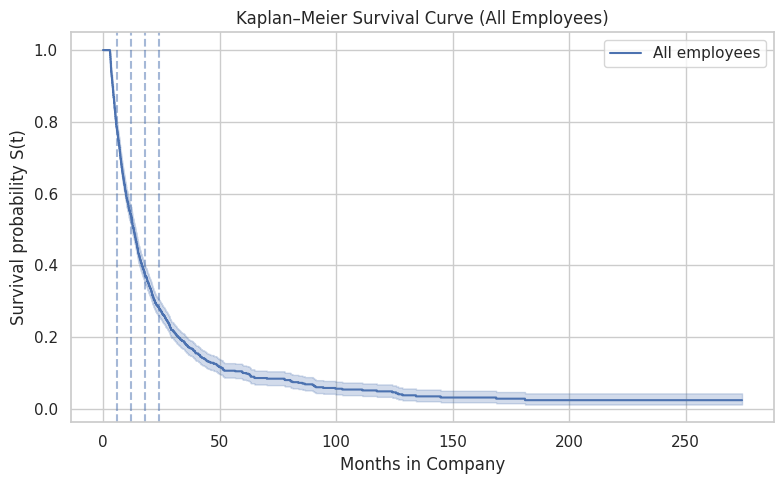

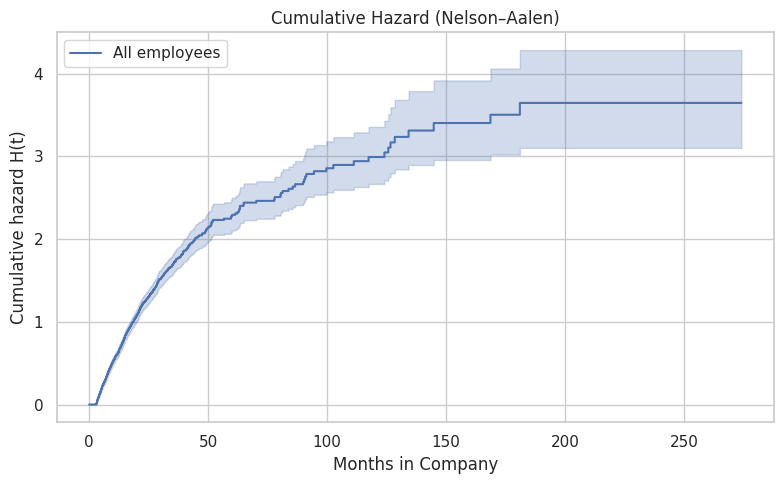

In [7]:
# [8]
from IPython.display import display
from lifelines import KaplanMeierFitter, NelsonAalenFitter

kmf = KaplanMeierFitter()
kmf.fit(durations=df_km[TENURE_COL], event_observed=df_km[EVENT_COL], label="All employees")

# --- עזר: רווחי סמך ב-Times ספציפיים (ללא confidence_interval_at_times) ---
def km_ci_at_times(kmf_obj, times):
    times = list(times)
    sf = kmf_obj.survival_function_.iloc[:, 0]
    timeline = kmf_obj.survival_function_.index.values

    # נסה לאתר טבלת CI לפי הגרסה
    ci_df = getattr(kmf_obj, "confidence_interval_", None)
    if ci_df is None:
        ci_df = getattr(kmf_obj, "confidence_interval_survival_function_", None)

    if ci_df is not None:
        lower_col = [c for c in ci_df.columns if "lower" in c][0]
        upper_col = [c for c in ci_df.columns if "upper" in c][0]

    rows = []
    for t in times:
        # קח את הערך האחרון ב-timeline שהוא <= t
        idx = np.searchsorted(timeline, t, side="right") - 1
        if idx < 0:  # לפני תחילת המעקב
            s = 1.0
            lo = up = 1.0 if ci_df is not None else np.nan
        else:
            s = float(sf.iloc[idx])
            if ci_df is not None:
                lo = float(ci_df.iloc[idx][lower_col])
                up = float(ci_df.iloc[idx][upper_col])
            else:
                lo = up = np.nan
        rows.append({"months": t, "S(t)": s, "S_lower": lo, "S_upper": up})
    return pd.DataFrame(rows)

# Survival ורווחי סמך בנקודות הזמן
S_at = kmf.survival_function_at_times(report_times).rename("S(t)")
km_table = km_ci_at_times(kmf, report_times)

# אם תרצי לאחד לטבלה אחת עם האינדקס של S_at:
km_table["S(t)"] = S_at.values

# עיגול והצגה
km_table = km_table[["months", "S(t)", "S_lower", "S_upper"]].round(3)
print("Kaplan–Meier Survival at key times (עם רווחי סמך 95%):")
display(km_table)

# שמירה לקובץ (לדו\"ח)
km_table.to_excel("/content/km_S_at_6_12_24.xlsx", index=False)
print("Saved to: /content/km_S_at_6_12_24.xlsx")

# גרף KM עם קווים אנכיים בנקודות הדיווח
plt.figure(figsize=(8,5))
kmf.plot(ci_show=True)
for t in report_times:
    plt.axvline(t, linestyle='--', alpha=0.5)
plt.title("Kaplan–Meier Survival Curve (All Employees)")
plt.xlabel("Months in Company")
plt.ylabel("Survival probability S(t)")
plt.tight_layout()
plt.show()

# Hazard מצטבר (Nelson–Aalen)
naf = NelsonAalenFitter()
naf.fit(durations=df_km[TENURE_COL], event_observed=df_km[EVENT_COL], label="All employees")
plt.figure(figsize=(8,5))
naf.plot()
plt.title("Cumulative Hazard (Nelson–Aalen)")
plt.xlabel("Months in Company")
plt.ylabel("Cumulative hazard H(t)")
plt.tight_layout()
plt.show()


בדיקת מובהקות ההבדלים בוותק העובד בארגון בין עוזבים לפעילים

In [8]:
# [9]
tenure_active   = df.loc[df[EVENT_COL]==0, TENURE_COL].dropna()
tenure_resigned = df.loc[df[EVENT_COL]==1, TENURE_COL].dropna()

# Mann–Whitney U (דו-זנבי)
U, p = mannwhitneyu(tenure_active, tenure_resigned, alternative='two-sided')

# Cliff's delta (גודל אפקט) מתוך U
n1, n2 = len(tenure_active), len(tenure_resigned)
delta = (2*U/(n1*n2)) - 1

def cliff_label(d):
    ad = abs(d)
    if ad < 0.147: return "זניח"
    if ad < 0.33:  return "קטן"
    if ad < 0.474: return "בינוני"
    return "גדול"

print("הבדלי ותק בין פעילים (status=0) לעוזבים (status=1)")
print(f"n_active={n1}, n_resigned={n2}")
print(f"Mann–Whitney U={U:,.0f}, p-value={p:.3e}")
print(f"Cliff's delta={delta:.3f}  →  גודל אפקט: {cliff_label(delta)}")

# סיכום תיאורי קצר (לדו״ח)
summary = pd.DataFrame({
    "Group": ["Active (0)", "Resigned (1)"],
    "N": [n1, n2],
    "Median tenure": [np.median(tenure_active), np.median(tenure_resigned)],
    "Mean tenure": [np.mean(tenure_active), np.mean(tenure_resigned)]
})
summary["Median tenure"] = summary["Median tenure"].round(2)
summary["Mean tenure"]   = summary["Mean tenure"].round(2)
display(summary)
summary.to_excel("/content/tenure_by_status_summary.xlsx", index=False)
print("Saved to: /content/tenure_by_status_summary.xlsx")


הבדלי ותק בין פעילים (status=0) לעוזבים (status=1)
n_active=412, n_resigned=1339
Mann–Whitney U=363,298, p-value=1.926e-22
Cliff's delta=0.317  →  גודל אפקט: קטן


,Group,N,Median tenure,Mean tenure
0,Active (0),412,16.98,25.38
1,Resigned (1),1339,9.83,14.98


Saved to: /content/tenure_by_status_summary.xlsx


עקומת אקס-פוסט לפי פילוח ותק

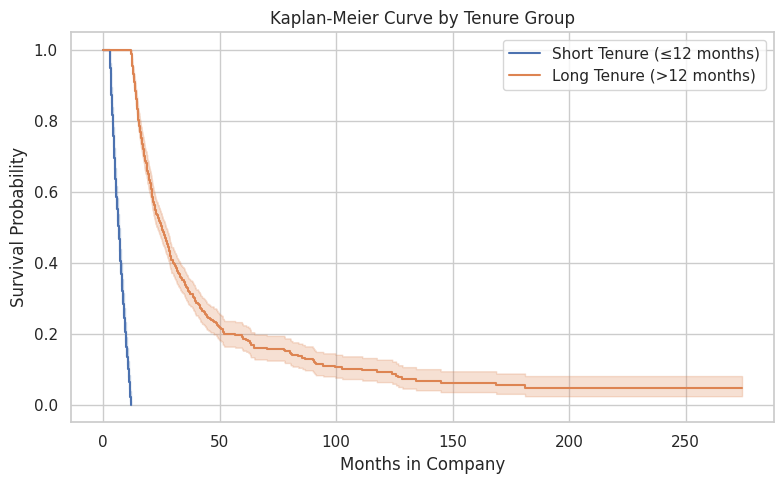

In [9]:
# [10]
# יצירת עותק עם עמודת פילוח לוותק
df['tenure_group'] = df['time_in_company'].apply(lambda x: 'Short Tenure (≤12 months)' if x <= 12 else 'Long Tenure (>12 months)')

# אתחול אובייקט KaplanMeierFitter
kmf = KaplanMeierFitter()

# ציור גרף
plt.figure(figsize=(8, 5))

for group in df['tenure_group'].unique():
    mask = df['tenure_group'] == group
    kmf.fit(durations=df[mask]['time_in_company'],
            event_observed=df[mask]['status'],
            label=group)
    kmf.plot(ci_show=True)  # עם רצועות אמון

plt.title("Kaplan-Meier Curve by Tenure Group")
plt.xlabel("Months in Company")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.show()


בדיקת  הבדלים בוותק בארגון בין פעילים לעוזבים

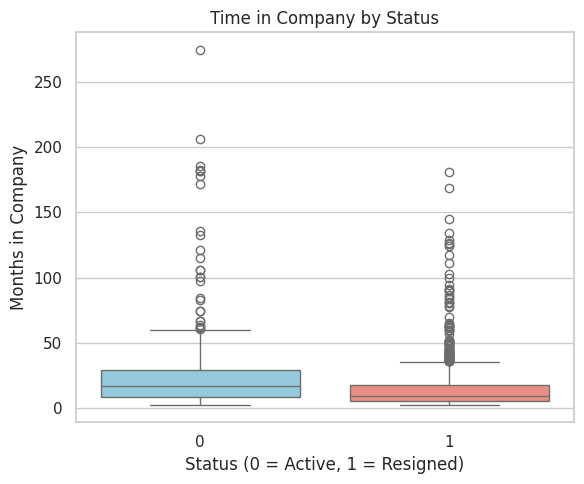

In [10]:
# [11]
plt.figure(figsize=(6, 5))
sns.boxplot(x='status', y='time_in_company', data=df, palette=['skyblue', 'salmon'])
plt.title('Time in Company by Status')
plt.xlabel('Status (0 = Active, 1 = Resigned)')
plt.ylabel('Months in Company')
plt.tight_layout()
plt.show()

בדיקת מובהקות להבדלים בוותק בין פעילים לעוזבים

In [11]:
#[12]
from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd

# פילוח לפי סטטוס
active = df[df['status'] == 0]['time_in_company'].dropna()
resigned = df[df['status'] == 1]['time_in_company'].dropna()

# מבחן Mann–Whitney
stat, p_value = mannwhitneyu(active, resigned, alternative='two-sided')

# Cliff's delta
n1, n2 = len(active), len(resigned)
delta = (2*stat/(n1*n2)) - 1

def cliff_label(d):
    ad = abs(d)
    if ad < 0.147: return "זניח"
    if ad < 0.33:  return "קטן"
    if ad < 0.474: return "בינוני"
    return "גדול"

print("Mann-Whitney U test:")
print(f"U-statistic = {stat:.2f}")
print(f"p-value = {p_value:.4f}")
print(f"Cliff's delta = {delta:.3f}  →  גודל אפקט: {cliff_label(delta)}")

# טבלה תיאורית
summary = pd.DataFrame({
    "Group": ["Active (0)", "Resigned (1)"],
    "N": [n1, n2],
    "Median tenure": [np.median(active), np.median(resigned)],
    "Mean tenure": [np.mean(active), np.mean(resigned)]
}).round(2)

print("\nSummary stats:")
print(summary.to_string(index=False))


Mann-Whitney U test:
U-statistic = 363297.50
p-value = 0.0000
Cliff's delta = 0.317  →  גודל אפקט: קטן

Summary stats:
       Group    N  Median tenure  Mean tenure
  Active (0)  412          16.98        25.38
Resigned (1) 1339           9.83        14.98


התפגות הגילאים - הבדלים בין פעילים לעוזבים

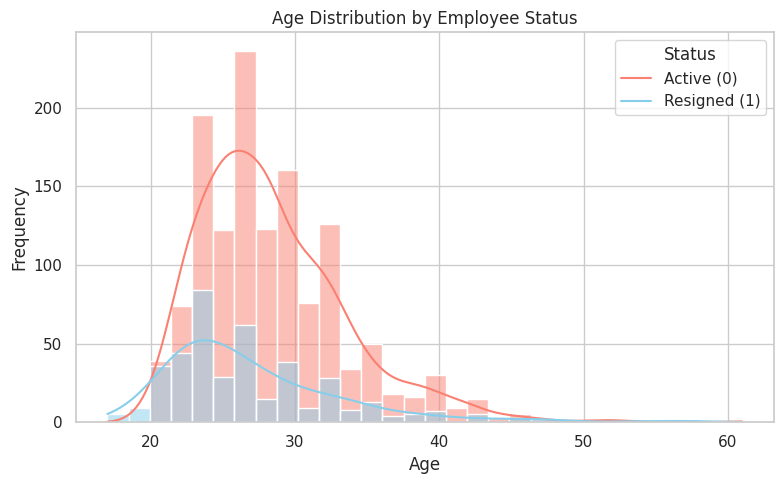

In [12]:
# [13]
plt.figure(figsize=(8,5))
sns.histplot(
    data=df,
    x="age",
    hue="status",
    bins=30,
    kde=True,
    palette={0: "skyblue", 1: "salmon"},  # Active=תכלת, Resigned=ורוד
    alpha=0.5,
    edgecolor=None   # <<< מסיר מסגרות
)
plt.title("Age Distribution by Employee Status")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend(title="Status", labels=["Active (0)", "Resigned (1)"])
plt.tight_layout()
plt.show()


הבדלי גיל בין פעילים לעוזבים - המשך

In [13]:
# [14]
from scipy import stats

g0 = df.loc[df['status']==0, 'age'].dropna()  # Active
g1 = df.loc[df['status']==1, 'age'].dropna()  # Resigned

# בדיקת נורמליות (מדגם עד 500 למניעת אזהרות)
def shapiro_p(x):
    x = x.sample(min(len(x), 500), random_state=0) if len(x) > 500 else x
    return stats.shapiro(x).pvalue if len(x) >= 3 else np.nan

p0, p1 = shapiro_p(g0), shapiro_p(g1)

if (p0 > 0.05) and (p1 > 0.05):
    # Welch t-test (שונות לא שווה)
    t, p = stats.ttest_ind(g0, g1, equal_var=False)
    # Cohen's d (אפקט סטנדרטי)
    n0, n1 = len(g0), len(g1)
    s_pooled = np.sqrt(((n0-1)*g0.var(ddof=1) + (n1-1)*g1.var(ddof=1)) / (n0+n1-2))
    d = (g0.mean() - g1.mean()) / s_pooled
    test_line = f"Welch t-test: t={t:.2f}, p={p:.3g} | Cohen's d={d:.2f}"
else:
    # Mann–Whitney U (לא פרמטרי) + Cliff's delta
    u, p = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    # Cliff's delta יעיל ללא לולאות:
    diff = np.subtract.outer(g0.values, g1.values)
    delta = (np.sum(diff > 0) - np.sum(diff < 0)) / (len(g0)*len(g1))
    test_line = f"Mann–Whitney U={u:.0f}, p={p:.3g} | Cliff's delta={delta:.2f}"

summary = pd.DataFrame({
    'Group': ['Active (0)', 'Resigned (1)'],
    'N': [len(g0), len(g1)],
    'Mean age': [g0.mean(), g1.mean()],
    'Median age': [g0.median(), g1.median()],
    'SD': [g0.std(ddof=1), g1.std(ddof=1)]
}).round(2)

print(test_line)
summary


Mann–Whitney U=216127, p=2.6e-11 | Cliff's delta=-0.22


,Group,N,Mean age,Median age,SD
0,Active (0),412,27.06,25.0,6.34
1,Resigned (1),1339,28.43,28.0,5.18


הבדלים בגיל בין פעילים לעוזבים - המשך

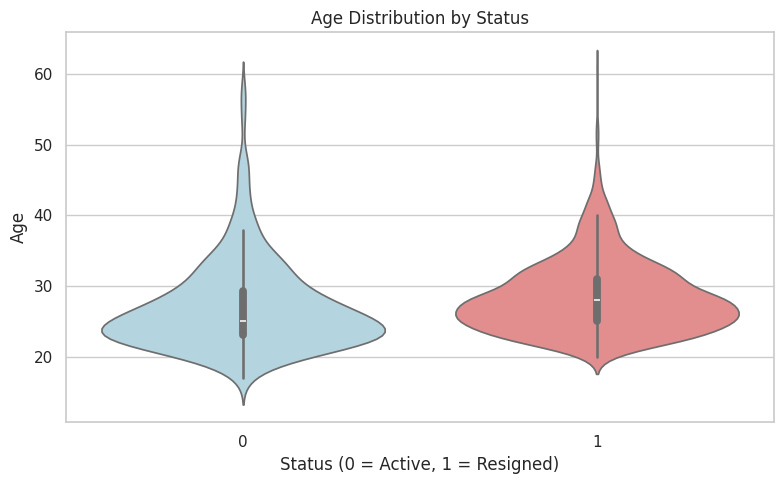

In [14]:
# [15]
plt.figure(figsize=(8, 5))
sns.violinplot(x='status', y='age', data=df, palette=['lightblue', 'lightcoral'])
plt.title('Age Distribution by Status')
plt.xlabel('Status (0 = Active, 1 = Resigned)')
plt.ylabel('Age')
plt.tight_layout()
plt.show()

הבדלים בניצול חופשה שנתית בין פעילים לעוזבים

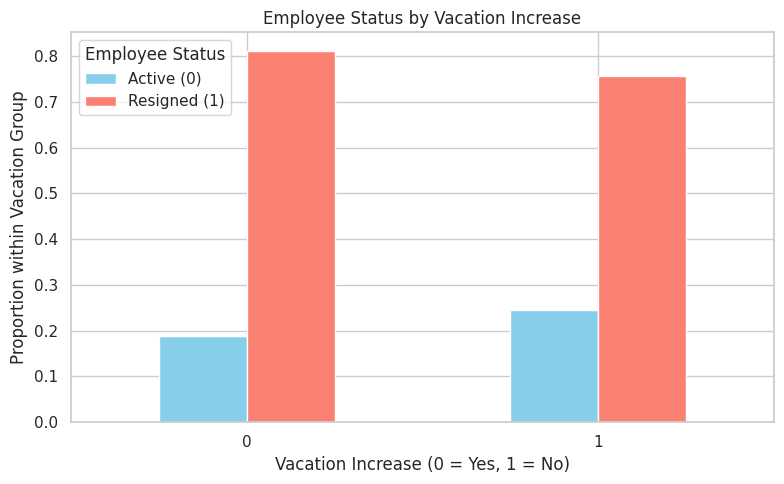

In [15]:
# [16]

# טבלת שכיחויות יחסית – אחוזי עוזבים/פעילים מתוך כל קבוצת vacation_increase
plot_data = df.groupby('avg_annual_vacation_increase')['status'].value_counts(normalize=True).unstack()

# ציור גרף עמודות
plot_data.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'])
plt.title('Employee Status by Vacation Increase')
plt.xlabel('Vacation Increase (0 = Yes, 1 = No)')
plt.ylabel('Proportion within Vacation Group')
plt.xticks(rotation=0)
plt.legend(['Active (0)', 'Resigned (1)'], title='Employee Status')
plt.tight_layout()
plt.show()



בדיקת מובהקות סטטיסטית להבדלים בניצול חופשה שנתית בין פעילים לעוזבים

In [16]:
# [17]
from scipy.stats import chi2_contingency, fisher_exact

# טבלת שכיחויות בין סטטוס להאם הייתה עלייה בחופשה
contingency_table = pd.crosstab(df['status'], df['avg_annual_vacation_increase'])
print("טבלת שכיחויות:")
print(contingency_table)

# נבדוק אם יש תאים קטנים מ-5:
if (contingency_table < 5).any().any():
    # מבחן פישר
    oddsratio, p_value = fisher_exact(contingency_table)
    print("\n מבחן פישר (Fisher's Exact Test):")
    print(f"Odds Ratio = {oddsratio:.4f}")
    print(f"p-value = {p_value:.4f}")
else:
    # מבחן חי בריבוע
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print("\n מבחן חי-בריבוע (Chi-Square Test):")
    print(f"Chi² = {chi2:.4f}")
    print(f"Degrees of Freedom = {dof}")
    print(f"p-value = {p_value:.4f}")


טבלת שכיחויות:
avg_annual_vacation_increase    0     1
status                                 
0                              55   357
1                             236  1103

 מבחן חי-בריבוע (Chi-Square Test):
Chi² = 3.8535
Degrees of Freedom = 1
p-value = 0.0496


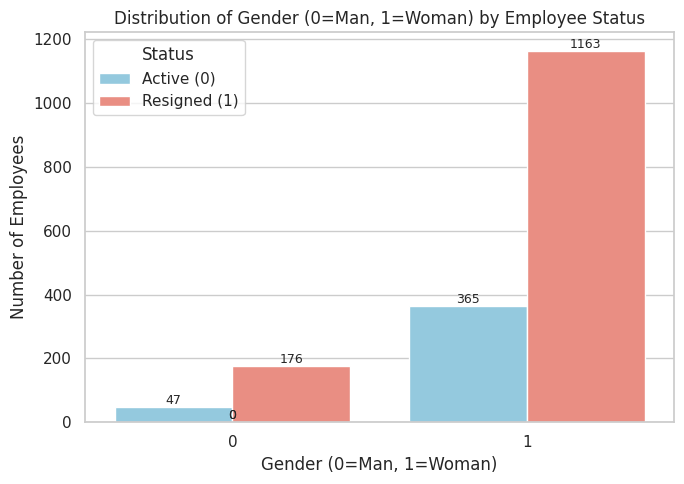

In [17]:
# [18]
plt.figure(figsize=(7,5))
ax = sns.countplot(
    data=df,
    x="gender",
    hue="status",
    palette=['skyblue','salmon'],
    dodge=True
)
# הוספת מספרים מעל כל עמודה
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9)

ax.set_title("Distribution of Gender (0=Man, 1=Woman) by Employee Status")
ax.set_xlabel("Gender (0=Man, 1=Woman)")
ax.set_ylabel("Number of Employees")
plt.legend(title="Status", labels=["Active (0)", "Resigned (1)"])
plt.tight_layout()
plt.show()


התפלגות ילדים לפי סטטוס

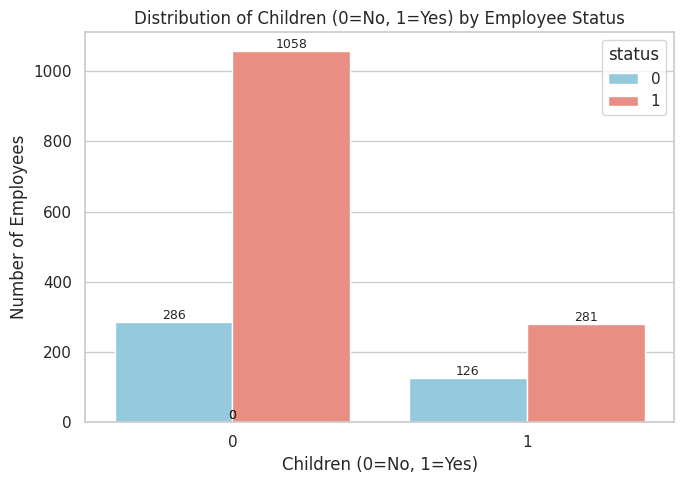

In [18]:
#[19]
plt.figure(figsize=(7,5))
ax = sns.countplot(
    data=df,
    x="children",
    hue="status",
    palette=['skyblue','salmon'],
    dodge=True
)
# הוספת מספרים מעל כל עמודה
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9)

ax.set_title("Distribution of Children (0=No, 1=Yes) by Employee Status")
ax.set_xlabel("Children (0=No, 1=Yes)")
ax.set_ylabel("Number of Employees")
plt.tight_layout()
plt.show()


כדי לבדוק האם הקשר בין ילדים לבין סטטוס העובד הוא מובהק סטטיסטית, נשתמש במבחן :
(chi2)

In [19]:
#[20]
from scipy.stats import chi2_contingency, fisher_exact

# טבלת שכיחויות בין סטטוס לילדים (0=בלי, 1=עם)
contingency_table = pd.crosstab(df['status'], df['children'])
print("טבלת שכיחויות:")
print(contingency_table)

# בדיקה אם יש תאים קטנים מ-5
if (contingency_table < 5).any().any():
    # מבחן פישר
    oddsratio, p_value = fisher_exact(contingency_table)
    print("\nמבחן פישר (Fisher's Exact Test):")
    print(f"Odds Ratio = {oddsratio:.3f}")
    print(f"p-value = {p_value:.4f}")
else:
    # מבחן חי בריבוע
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print("\nמבחן חי בריבוע (Chi-Square Test):")
    print(f"Chi² = {chi2:.3f}")
    print(f"Degrees of Freedom = {dof}")
    print(f"p-value = {p_value:.4f}")

# טבלת אחוזים
summary = pd.crosstab(df['children'], df['status'], normalize='index') * 100
print("\nהתפלגות באחוזים (שורות מסכמות ל-100%):")
print(summary.round(2))


טבלת שכיחויות:
children     0    1
status             
0          286  126
1         1058  281

מבחן חי בריבוע (Chi-Square Test):
Chi² = 15.730
Degrees of Freedom = 1
p-value = 0.0001

התפלגות באחוזים (שורות מסכמות ל-100%):
status        0      1
children              
0         21.28  78.72
1         30.96  69.04


בדיקת מובהקות להבדלים בהתפלגות הילדים בין פעילים לעוזבים - המשך

Contingency table (status × children):
 children     0    1
status             
0          286  126
1         1058  281
Chi-square = 15.73, p = 0.0001


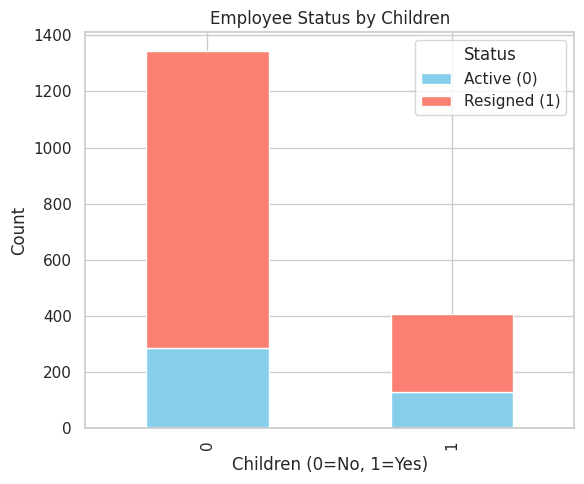

In [20]:
# [21]
import scipy.stats as st

# טבלת מבחן: סטטוס × ילדים
tbl_test = pd.crosstab(df['status'], df['children'])
chi2, p_chi, _, _ = st.chi2_contingency(tbl_test)

print("Contingency table (status × children):\n", tbl_test)
print(f"Chi-square = {chi2:.2f}, p = {p_chi:.4f}")

# גרף: ציר X = Children, אגדה = Status
tbl_plot = pd.crosstab(df['children'], df['status'])
tbl_plot.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], figsize=(6,5))
plt.title("Employee Status by Children")
plt.xlabel("Children (0=No, 1=Yes)")
plt.ylabel("Count")
plt.legend(["Active (0)", "Resigned (1)"], title="Status")
plt.tight_layout()
plt.show()


הבדלים בוותק בעת העזיבה בין המוקדים

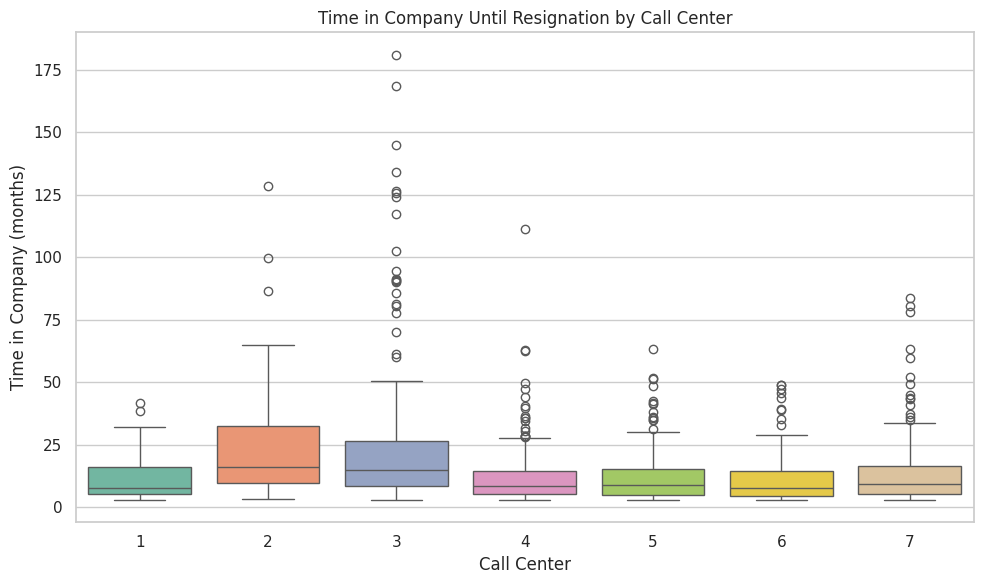

In [21]:
# [22]
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['status'] == 1], x='call_center', y='time_in_company', palette='Set2')
plt.title('Time in Company Until Resignation by Call Center')
plt.xlabel('Call Center')
plt.ylabel('Time in Company (months)')
plt.tight_layout()
plt.show()


בדיקת מובהקות ההבדלים בוותק בעת העזיבה בין המוקדים

In [22]:
# [23]
from scipy.stats import kruskal

# ניצור רשימה של קבוצות לפי מוקדים
groups = [group['time_in_company'].values for _, group in df[df['status'] == 1].groupby('call_center')]

# מבחן קרוסקל-ואליס
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis Test:\nStatistic = {stat:.4f}, p-value = {p:.4f}")


Kruskal-Wallis Test:
Statistic = 87.7604, p-value = 0.0000


בחינת הבדלים בין המוקדים - המשך

In [23]:
# [24]
# !pip -q install scikit-posthocs

import sys
# מתקין לתוך פרשן הפייתון של המחברת הנוכחית
!{sys.executable} -m pip install -q --upgrade pip
!{sys.executable} -m pip install -q scikit-posthocs

import scikit_posthocs as sp
print("scikit_posthocs:", sp.__version__)


import numpy as np
import pandas as pd
import scikit_posthocs as sp
from scipy.stats import kruskal

# ננתח רק עוזבים
df_res = df[df['status'] == 1].copy()

# תיאור לכל מוקד
by_cc = (df_res.groupby('call_center')['time_in_company']
         .agg(N='size', Median='median', Mean='mean',
              IQR=lambda s: np.subtract(*np.percentile(s.dropna(), [75, 25]))))
display(by_cc)

# Kruskal–Wallis
groups = [g['time_in_company'].dropna().values for _, g in df_res.groupby('call_center')]
H_stat, p_kw = kruskal(*groups)
print(f"Kruskal–Wallis: H = {H_stat:.4f}, p = {p_kw:.4f}")

# Dunn post-hoc (Holm)
p_dunn = sp.posthoc_dunn(df_res, val_col='time_in_company', group_col='call_center', p_adjust='holm')
display(p_dunn)

# Epsilon-squared
k = df_res['call_center'].nunique()
N = len(df_res)
epsilon_sq = (H_stat - k + 1) / (N - k)
print(f"Epsilon-squared (overall effect) = {epsilon_sq:.3f}")


scikit_posthocs: 0.11.4


,N,Median,Mean,IQR
call_center,,,,
1,85,7.833333,11.713725,11.000000
2,73,16.066667,25.080822,22.733333
3,211,14.933333,24.764929,17.866667
4,228,8.416667,12.237135,8.916667
5,172,8.950000,12.566667,10.300000
6,167,7.833333,11.393014,9.966667
7,403,9.466667,12.798428,11.433333


Kruskal–Wallis: H = 87.7604, p = 0.0000


,1,2,3,4,5,6,7
1,1.000000,3.486853e-05,1.945774e-05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
2,0.000035,1.000000e+00,1.000000e+00,1.532957e-06,8.140167e-06,9.931094e-08,6.206980e-06
3,0.000019,1.000000e+00,1.000000e+00,1.388989e-08,4.944603e-07,5.720156e-10,2.444213e-08
4,1.000000,1.532957e-06,1.388989e-08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
5,1.000000,8.140167e-06,4.944603e-07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
6,1.000000,9.931094e-08,5.720156e-10,1.000000e+00,1.000000e+00,1.000000e+00,6.428100e-01
7,1.000000,6.206980e-06,2.444213e-08,1.000000e+00,1.000000e+00,6.428100e-01,1.000000e+00


Epsilon-squared (overall effect) = 0.061


In [24]:
# [25]
# !pip -q install lifelines

import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

# ===== הגדרות =====
ORD_VAR = 'Team_size'   # <<< אם אצלך זה 'team_size_cat' - עדכני כאן
TIME_COL = 'time_in_company'
EVENT_COL = 'status'

# ===== הכנת הדאטה =====
cols = [TIME_COL, EVENT_COL, ORD_VAR]
df_cox = (df[cols]
          .dropna()
          .copy())

# וידוא טיפוסים
df_cox[ORD_VAR] = pd.to_numeric(df_cox[ORD_VAR], errors='coerce')
df_cox = df_cox.dropna(subset=[ORD_VAR])

# בדיקת התפלגות אירועים לכל דרגה (כדי לאתר דרגות דלילות)
events_by_grade = df_cox.groupby(ORD_VAR)[EVENT_COL].agg(events='sum', n='count')
print('Events / N by grade:\n', events_by_grade, '\n')

# ===== התאמת קוקס חד-משתני עם קידוד סדרתי =====
cph_ord = CoxPHFitter()
cph_ord.fit(df_cox[[TIME_COL, EVENT_COL, ORD_VAR]],
            duration_col=TIME_COL, event_col=EVENT_COL, robust=True)
print('\n== CoxPH (ordinal coding) summary ==')
display(cph_ord.summary[['coef','se(coef)','exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']])

# HR לעליה של דרגה אחת
beta = cph_ord.params_[ORD_VAR]
se   = cph_ord.standard_errors_[ORD_VAR]
HR_per_grade      = np.exp(beta)
HR_per_grade_low  = np.exp(beta - 1.96*se)
HR_per_grade_high = np.exp(beta + 1.96*se)
print(f"\nHazard Ratio per one-grade increase in {ORD_VAR}: "
      f"{HR_per_grade:.3f} (95% CI {HR_per_grade_low:.3f}–{HR_per_grade_high:.3f})")


Events / N by grade:
            events    n
Team_size             
1             215  253
2              92  129
3             383  472
4             520  701
5             129  196 


== CoxPH (ordinal coding) summary ==


,coef,se(coef),exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p
covariate,,,,,,
Team_size,0.032547,0.023948,1.033083,0.985713,1.08273,0.174126



Hazard Ratio per one-grade increase in Team_size: 1.033 (95% CI 0.986–1.083)


יצירת משתנה חדש - שכר יחסי (חודשי)

In [25]:
#[26]
import pandas as pd

# קריאת הדאטה
file_path = "/content/DATA.xlsx"
df = pd.read_excel(file_path, sheet_name="data")

# פונקציה למציאת שכר מינימום לפי שנה וחודש
def get_min_wage(year, month, status):
    if status == 0:  # פעיל
        return 5880.02
    # עזב → לפי תאריך עזיבה
    if year == 2017 and month <= 11:
        return 5000
    elif (year == 2017 and month == 12) or (2018 <= year <= 2022) or (year == 2023 and month <= 3):
        return 5300
    elif (year == 2023 and month >= 4) or (year == 2024 and month <= 3):
        return 5571.75
    elif (year == 2024 and month >= 4):
        return 5880.02
    return None

# נרמול למשרה מלאה (178 שעות + פרמיות)
df["monthly_salary_fulltime"] = (
    (df["salary_per_hour"] * 178) + df["bonus_avg"]
)

# קביעת שכר מינימום לכל עובד
df["min_wage_for_period"] = df.apply(
    lambda row: get_min_wage(
        row.get("resignation_year", 2024),
        row.get("resignation_month", 1),
        row["status"]
    ),
    axis=1
)

# חישוב שכר יחסי (יחס)
df["relative_salary"] = df["monthly_salary_fulltime"] / df["min_wage_for_period"]

# חישוב פער בשקלים (אופציונלי)
df["wage_gap"] = df["monthly_salary_fulltime"] - df["min_wage_for_period"]

# הדפסת 5 דוגמאות לבדיקה
print(df[["id", "status", "resignation_year", "resignation_month",
          "salary_per_hour", "part_time_percent", "bonus_avg",
          "monthly_salary_fulltime", "min_wage_for_period",
          "relative_salary", "wage_gap"]].head(5))


   id  status  resignation_year  resignation_month  salary_per_hour  \
0   1       0               NaN                NaN            30.00   
1   2       0               NaN                NaN            30.00   
2   3       0               NaN                NaN            30.00   
3   4       0               NaN                NaN            41.25   
4   5       0               NaN                NaN            40.82   

   part_time_percent  bonus_avg  monthly_salary_fulltime  min_wage_for_period  \
0           0.305770     312.00                  5652.00              5880.02   
1           0.468796     518.67                  5858.67              5880.02   
2           0.279720     202.00                  5542.00              5880.02   
3           0.718655    4313.89                 11656.39              5880.02   
4           0.393053    1427.00                  8692.96              5880.02   

   relative_salary  wage_gap  
0         0.961221   -228.02  
1         0.996369    -2

התפלגות של שכר יחסי לשכר מינימום

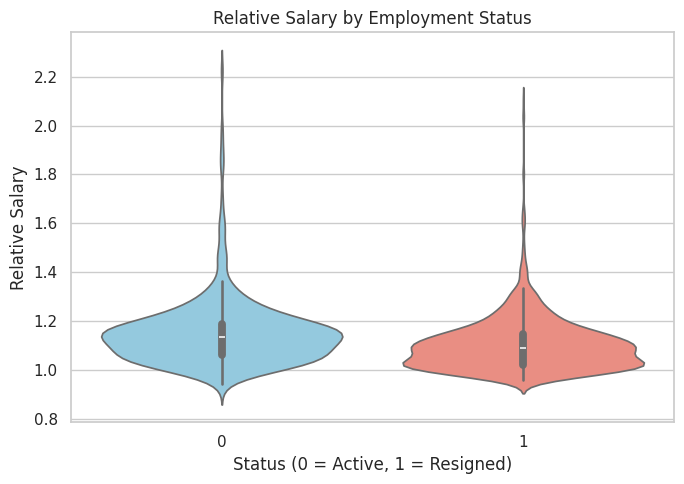

In [26]:
# [27]
import matplotlib.pyplot as plt
import seaborn as sns

col = "relative_salary"

plt.figure(figsize=(7,5))
sns.violinplot(
    x="status", y=col, data=df,
    palette=["skyblue", "salmon"],  # סדר קבוע: [0,1]
    inner="box"
)
plt.title("Relative Salary by Employment Status")
plt.xlabel("Status (0 = Active, 1 = Resigned)")
plt.ylabel("Relative Salary")
plt.tight_layout()
plt.show()




בדיקת מובהקות ההבדלים בשכר יחסי בין פעילים לעוזבים

In [27]:
# [28]

import numpy as np
import pandas as pd
from scipy import stats

# חלוקה לשתי קבוצות
g0 = df.loc[df["status"]==0, "relative_salary"].dropna()  # פעילים
g1 = df.loc[df["status"]==1, "relative_salary"].dropna()  # עוזבים

# בדיקת נורמליות (שאפירו-וילק; לוקחים דגימה עד 500 כדי למנוע אזהרות)
def shapiro_p(x):
    x = x.sample(min(len(x), 500), random_state=0) if len(x) > 500 else x
    return stats.shapiro(x).pvalue if len(x) >= 3 else np.nan

p0, p1 = shapiro_p(g0), shapiro_p(g1)

if (p0 > 0.05) and (p1 > 0.05):
    # נורמליות – נבצע Welch t-test
    t, p = stats.ttest_ind(g0, g1, equal_var=False)
    # גודל אפקט: Cohen's d
    n0, n1 = len(g0), len(g1)
    s_pooled = np.sqrt(((n0-1)*g0.var(ddof=1) + (n1-1)*g1.var(ddof=1)) / (n0+n1-2))
    d = (g0.mean() - g1.mean()) / s_pooled
    print(f"Welch t-test: t={t:.2f}, p={p:.3g} | Cohen's d={d:.2f}")
else:
    # לא נורמלי – מבחן מנ–ויטני + Cliff's delta
    u, p = stats.mannwhitneyu(g0, g1, alternative="two-sided")
    diff = np.subtract.outer(g0.values, g1.values)
    delta = (np.sum(diff > 0) - np.sum(diff < 0)) / (len(g0)*len(g1))
    print(f"Mann–Whitney U={u:.0f}, p={p:.3g} | Cliff's delta={delta:.2f}")

# טבלת סיכום
summary = pd.DataFrame({
    "Group": ["Active (0)", "Resigned (1)"],
    "N": [len(g0), len(g1)],
    "Mean": [g0.mean(), g1.mean()],
    "Median": [g0.median(), g1.median()],
    "SD": [g0.std(ddof=1), g1.std(ddof=1)]
}).round(3)

print("\nSummary table:")
print(summary)



Mann–Whitney U=347180, p=1.85e-15 | Cliff's delta=0.26

Summary table:
          Group     N   Mean  Median     SD
0    Active (0)   412  1.151   1.135  0.142
1  Resigned (1)  1339  1.104   1.088  0.113


Mann–Whitney U = 395,097

p-value = 2.04e-15 → מובהקות גבוהה מאוד (p < 0.001).

Cliff’s delta = 0.25 → גודל אפקט קטן עד בינוני (כלומר ההבדל קיים, אך לא עצום).  
עובדים פעילים: שכר יחסי ממוצע = 1.146 → כלומר בממוצע ~15% מעל שכר המינימום.

עובדים שעזבו: שכר יחסי ממוצע = 1.104 → כלומר בממוצע ~10% מעל שכר המינימום.

הפער: בערך 0.04 נקודות יחסיות (כ־4% הבדל).  
סטטיסטית – יש הבדל מובהק: העובדים הפעילים מרוויחים יחסית יותר מעל שכר המינימום לעומת העובדים שעזבו.

מעשית – גודל האפקט לא ענק. המשמעות: ייתכן ששכר אכן משחק תפקיד בהחלטה לעזוב, אבל זה כנראה לא הגורם היחיד אלא חלק מתמונה רחבה יותר (משמרות, עומס, ניהול וכו’).

הטיה הוסרה – בזכות השכר היחסי (מנורמל לפי שנת עזיבה) הצלחת לנטרל את הבעיה של שינויים בשכר מינימום לאורך זמן.  


בחינת קשר בין % משרה לעזיבה

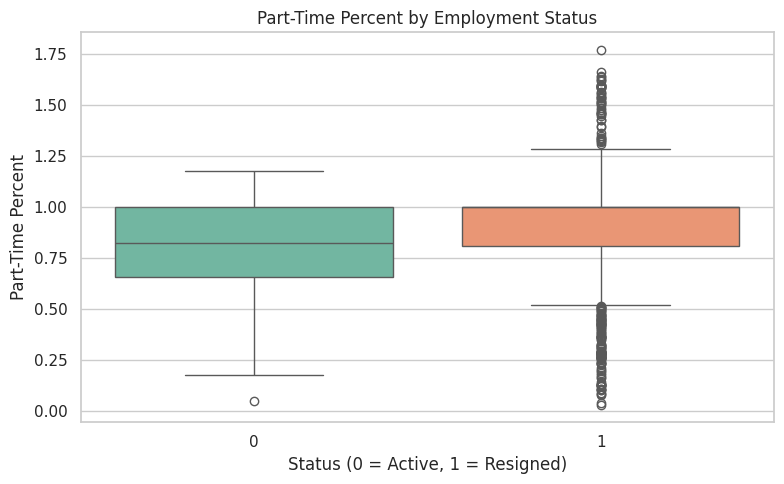

In [28]:
# [29]
plt.figure(figsize=(8, 5))
sns.boxplot(x='status', y='part_time_percent', data=df, palette='Set2')
plt.title('Part-Time Percent by Employment Status')
plt.xlabel('Status (0 = Active, 1 = Resigned)')
plt.ylabel('Part-Time Percent')
plt.tight_layout()
plt.show()


בדיקת מובהקות ההבדלים ב% משרה בין פעילים לעוזבים

In [29]:
# [30]
from scipy.stats import mannwhitneyu
import numpy as np

# חלוקה לפי סטטוס והסרת חסרים
group_active = df.loc[df['status'] == 0, 'salary_per_hour'].dropna()
group_resigned = df.loc[df['status'] == 1, 'salary_per_hour'].dropna()

# מבחן Mann–Whitney U
u_statistic, p_value = mannwhitneyu(group_active, group_resigned, alternative='two-sided')

# חישוב Z ואפקט (r)
n1, n2 = len(group_active), len(group_resigned)
mean_U = n1 * n2 / 2
std_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
z = (u_statistic - mean_U) / std_U
r = z / np.sqrt(n1 + n2)

print(f"U-statistic: {u_statistic:.0f}")
print(f"Z-score: {z:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Effect size (r): {r:.4f}")


U-statistic: 515208
Z-score: 26.6723
p-value: 0.0000
Effect size (r): 0.6374


# **השלמת ערכים חסרים**

שלבי השלמת ערכים חסרים בשיטת MICE
לפי מוקד, למשתנים הבאים:  

answered_calls_vs_center_avg, answered_calls_vs_employee_avg, call_duration_vs_center_avg, call_duration_vs_employee_avg, calls_perhour_vs_center_avg, calls_perhour_vs_employee_avg.

In [30]:
# [31] אימפיוט KPI בלבד (פר-מוקד) לפי ההגדרות החדשות
import numpy as np
import pandas as pd

from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler

# ===== בדיקת קיום df =====
try:
    df
except NameError:
    raise RuntimeError("לא נמצא df בזיכרון. טעני את הנתונים ל-DataFrame בשם df לפני הרצת התא.")

# נעבוד על עותק
df_imputed = df.copy()

# ===== עוגנים =====
TENURE_COL = "time_in_company"   # משך המעקב (חודשים)
EVENT_COL  = "status"            # 0=מצונזר/פעיל, 1=עזב
GROUP_COL  = "call_center"       # חלוקה למוקדים עבור אימפיוט לפי מוקד

# ===== משתני KPI מקוריים (12 משתנים) =====
KPI_COLS_DECLARED = [
    "answered_calls_employee_avg_3month",
    "call_duration_employee_avg_3month",
    "calls_perhour_employee_avg_3month",
    "pause_center_employee_avg_3month",
    "answered_calls_employee_avg",
    "call_duration_employee_avg",
    "calls_perhour_employee_avg",
    "pause_center_employee_avg",
    "answered_calls_center_avg",
    "call_duration_center_avg",
    "calls_perhour_center_avg",
    "pause_center_avg"
]

# בפועל נשתמש רק במה שקיים בעמודות
KPI_COLS = [c for c in KPI_COLS_DECLARED if c in df_imputed.columns]
if len(KPI_COLS) == 0:
    raise ValueError("לא נמצאו עמודות KPI מוכרות ב-DataFrame. בדקי שמות עמודות ה-KPI.")

# פונקציית עזר לספירת חסרים
def count_missing(cols):
    cols = [c for c in cols if c in df_imputed.columns]
    if not cols:
        return 0
    return int(df_imputed[cols].isna().sum().sum())

print(f"• חסרים לפני — KPI: {count_missing(KPI_COLS):,}")

# ===== הגדרות אלגוריתם =====
rng = 42
min_rows_for_regression = 5   # פחות מזה → מילוי חציונים (fallback)
max_iter = 25
tol = 1e-3

# אם אין עמודת מוקד, נבצע אימפיוט גלובלי
if GROUP_COL not in df_imputed.columns:
    print(f"'{GROUP_COL}' לא קיימת — נבצע אימפיוט גלובלי (נגדיר קבוצת ALL).")
    df_imputed[GROUP_COL] = "ALL"

centers = df_imputed[GROUP_COL].astype(str).fillna("ALL").unique()

used_mice, used_median = [], []
iters_by_center = {}

for center in centers:
    mask = (df_imputed[GROUP_COL].astype(str) == str(center))
    block_num = df_imputed.loc[mask, KPI_COLS].copy()

    # אם כל שורה ריקה לגמרי
    n_non_all_na_rows = block_num.dropna(how='all').shape[0]

    # עמודות NaN לחלוטין במוקד
    all_na_cols = [c for c in KPI_COLS if block_num[c].isna().all()]
    for c in all_na_cols:
        global_med = df_imputed[c].median()
        block_num[c] = block_num[c].fillna(global_med)

    # מוקד קטן מדי → מילוי חציונים
    if n_non_all_na_rows < max(2, min_rows_for_regression):
        for c in block_num.columns:
            med_center = block_num[c].median()
            if pd.isna(med_center):
                med_center = df_imputed[c].median()
            block_num[c] = block_num[c].fillna(med_center)
        df_imputed.loc[mask, KPI_COLS] = block_num.values
        used_median.append(str(center))
        iters_by_center[str(center)] = -1
        print(f"[{center}] n={n_non_all_na_rows} קטן — מילוי KPI בחציונים (fallback).")
        continue

    # סטנדרטיזציה + MICE
    scaler = StandardScaler(with_mean=True, with_std=True)
    num_scaled = pd.DataFrame(
        scaler.fit_transform(block_num),
        columns=block_num.columns, index=block_num.index
    )

    mice = IterativeImputer(
        estimator=BayesianRidge(),
        max_iter=max_iter,
        tol=tol,
        random_state=rng,
        initial_strategy="median",
        sample_posterior=False,
        imputation_order="ascending",
        skip_complete=True
    )

    try:
        imputed_scaled = pd.DataFrame(
            mice.fit_transform(num_scaled),
            columns=num_scaled.columns, index=num_scaled.index
        )
        iters_by_center[str(center)] = int(getattr(mice, "n_iter_", 0))

        imputed_num = pd.DataFrame(
            scaler.inverse_transform(imputed_scaled.values),
            columns=imputed_scaled.columns, index=imputed_scaled.index
        )

        # גיבוי נקודתי אם נותרו NaN
        for c in imputed_num.columns:
            if imputed_num[c].isna().any():
                med = imputed_num[c].median()
                if pd.isna(med):
                    med = df_imputed[c].median()
                imputed_num[c] = imputed_num[c].fillna(med)

        df_imputed.loc[mask, KPI_COLS] = imputed_num.values
        used_mice.append(str(center))

    except Exception as e:
        print(f"[{center}] כשל באימפיוט MICE ({type(e).__name__}: {e}) — נופל לחציונים.")
        fill = block_num.copy()
        for c in fill.columns:
            med = fill[c].median()
            if pd.isna(med):
                med = df_imputed[c].median()
            fill[c] = fill[c].fillna(med)
        df_imputed.loc[mask, KPI_COLS] = fill.values
        used_median.append(str(center))
        iters_by_center[str(center)] = -1

# גיבוי גלובלי אחרון
for c in KPI_COLS:
    if df_imputed[c].isna().any():
        df_imputed[c] = df_imputed[c].fillna(df_imputed[c].median())

print(f"• חסרים אחרי — KPI: {count_missing(KPI_COLS):,}")
print("✓ אימפיוט הושלם: נומריים (12 KPI מקוריים) פר-מוקד: MICE+BayesianRidge; fallback=חציונים.\n")

# דוח קצר
print("סיכום אימפיוט:")
print(f"- מוקדים ש-MICE עבד בהם: {len(used_mice)} → {sorted(used_mice)}")
print(f"- מוקדים שנפלו ל-Median: {len(used_median)} → {sorted(used_median)}")
print("\nאיטרציות בפועל (n_iter_) לפי מוקד:")
for k in sorted(iters_by_center):
    print(f"  {k}: {iters_by_center[k]} סיבובים")
# ===== שמירת הקובץ עם הערכים שהושלמו =====
output_path = "/content/kpi_imputed.xlsx"
df_imputed.to_excel(output_path, index=False)

print(f"\n✓ קובץ הנתונים עם ערכים מושלמים נשמר כ: {output_path}")


• חסרים לפני — KPI: 5,544
• חסרים אחרי — KPI: 0
✓ אימפיוט הושלם: נומריים (12 KPI מקוריים) פר-מוקד: MICE+BayesianRidge; fallback=חציונים.

סיכום אימפיוט:
- מוקדים ש-MICE עבד בהם: 7 → ['1', '2', '3', '4', '5', '6', '7']
- מוקדים שנפלו ל-Median: 0 → []

איטרציות בפועל (n_iter_) לפי מוקד:
  1: 8 סיבובים
  2: 13 סיבובים
  3: 18 סיבובים
  4: 25 סיבובים
  5: 5 סיבובים
  6: 12 סיבובים
  7: 6 סיבובים

✓ קובץ הנתונים עם ערכים מושלמים נשמר כ: /content/kpi_imputed.xlsx


בדיקת שמירה על התפלגות (לפני ואחרי השלמת ערכים חסרים)

In [ ]:
# [33] – Distribution Before vs. After Imputation (מותאם ל-12 KPI מקוריים)

import numpy as np, pandas as pd, matplotlib.pyplot as plt
import math
from pathlib import Path
import warnings

# ----- אימות קיום ה־DFים -----
if 'df' not in globals() or 'df_imputed' not in globals():
    raise RuntimeError("חסרים df ו/או df_imputed בזיכרון. ודאי שטענת את שני המסגרות.")

# ----- עמודות רציפות למעקב (12 KPI מקוריים) -----
continuous_cols = [
    "answered_calls_employee_avg_3month",
    "call_duration_employee_avg_3month",
    "calls_perhour_employee_avg_3month",
    "pause_center_employee_avg_3month",
    "answered_calls_employee_avg",
    "call_duration_employee_avg",
    "calls_perhour_employee_avg",
    "pause_center_employee_avg",
    "answered_calls_center_avg",
    "call_duration_center_avg",
    "calls_perhour_center_avg",
    "pause_center_avg"
]

# לשמור רק על עמודות שקיימות בפועל
continuous_cols = [c for c in continuous_cols if c in df.columns and c in df_imputed.columns]
if not continuous_cols:
    raise ValueError("לא נמצאו עמודות רציפות משותפות בין df ל-df_imputed.")

# ----- תצורת פלט -----
OUT_DIR = Path(globals().get('OUT_DIR', '/content/cox_fs_runs_final'))
OUT_DIR.mkdir(parents=True, exist_ok=True)

IMPUTATION_METHOD = globals().get('IMPUTATION_METHOD', 'MICE + BayesianRidge')

# ----- פונקציית עזר -----
def can_kde(series: pd.Series) -> bool:
    s = pd.to_numeric(series, errors='coerce').dropna()
    return (len(s) >= 10) and (s.nunique(dropna=True) >= 2)

# ----- גריד ציור -----
n = len(continuous_cols)
ncols = 2
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4*nrows))
axes = np.array(axes).reshape(nrows, ncols)
fig.suptitle(f"Distribution Before vs. After Imputation – {IMPUTATION_METHOD}",
             fontsize=14, fontweight='bold')

summary_rows = []

for ax, col in zip(axes.flatten(), continuous_cols):
    before = pd.to_numeric(df[col], errors='coerce').dropna()
    after  = pd.to_numeric(df_imputed[col], errors='coerce').dropna()

    # טווח X חזק (קוונטילים)
    both = pd.concat([before, after], axis=0)
    if len(both):
        try:
            xmin = float(np.nanpercentile(both, 1))
            xmax = float(np.nanpercentile(both, 99))
            if not np.isfinite(xmin) or not np.isfinite(xmax) or xmin == xmax:
                raise ValueError
        except Exception:
            xmin = float(np.nanmin(both)) if np.isfinite(np.nanmin(both)) else -1.0
            xmax = float(np.nanmax(both)) if np.isfinite(np.nanmax(both)) else  1.0
            if not np.isfinite(xmin) or not np.isfinite(xmax) or xmin == xmax:
                xmin, xmax = -1.0, 1.0
    else:
        xmin, xmax = -1.0, 1.0

    # KDE / Hist
    try:
        import seaborn as sns
        if can_kde(before):
            sns.kdeplot(before, ax=ax, fill=True, alpha=0.35, label='Before')
        else:
            ax.hist(before, bins='auto', density=True, alpha=0.4, label='Before')

        if can_kde(after):
            sns.kdeplot(after, ax=ax, fill=True, alpha=0.35, label='After')
        else:
            ax.hist(after,  bins='auto', density=True, alpha=0.4, label='After')
    except Exception:
        ax.hist(before, bins='auto', density=True, alpha=0.4, label='Before')
        ax.hist(after,  bins='auto', density=True, alpha=0.4, label='After')

    # קווי חציון
    if len(before):
        ax.axvline(float(np.median(before)), linestyle='--', linewidth=1, alpha=0.9, label='Median (Before)')
    if len(after):
        ax.axvline(float(np.median(after)),  linestyle='-.', linewidth=1, alpha=0.9, label='Median (After)')

    ax.set_xlim(xmin, xmax)
    ax.set_title(f"{col}", fontsize=11)
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.legend()

    # טבלת סיכום למדד זה
    summary_rows.append({
        "column": col,
        "n_before": int(before.shape[0]),
        "n_after":  int(after.shape[0]),
        "missing_before": int(df[col].isna().sum()),
        "missing_after":  int(df_imputed[col].isna().sum()),
        "mean_before": float(np.nanmean(before)) if len(before) else np.nan,
        "mean_after":  float(np.nanmean(after))  if len(after)  else np.nan,
        "median_before": float(np.nanmedian(before)) if len(before) else np.nan,
        "median_after":  float(np.nanmedian(after))  if len(after)  else np.nan,
        "std_before": float(np.nanstd(before, ddof=1)) if len(before) > 1 else np.nan,
        "std_after":  float(np.nanstd(after,  ddof=1)) if len(after)  > 1 else np.nan,
    })

# הסתרת סאבפלוטים ריקים
for i in range(n, nrows*ncols):
    axes.flatten()[i].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# שמירה: תרשים + CSV סיכום
safe_tag = IMPUTATION_METHOD.replace(' ', '_').replace('/', '-')
fig_path = OUT_DIR / f"imputation_distributions_{safe_tag}.png"
plt.savefig(fig_path, dpi=140)
plt.show()

summary_df = pd.DataFrame(summary_rows)
sum_path = OUT_DIR / f"imputation_distributions_summary_{safe_tag}.csv"
summary_df.to_csv(sum_path, index=False)

print(f"נשמר התרשים אל: {fig_path}")
print(f"נשמרה טבלת הסיכום אל: {sum_path}")


יצירת משתנים חדשים של פער

In [ ]:
# חישוב ושמירת משתני הפערים/יחסים ישירות בתוך df

# פערים
df['answered_calls_vs_center_avg'] = (
    df['answered_calls_employee_avg_3month'] - df['answered_calls_center_avg']
)

df['answered_calls_vs_employee_avg'] = (
    df['answered_calls_employee_avg_3month'] - df['answered_calls_employee_avg']
)

df['call_duration_vs_center_avg'] = (
    df['call_duration_employee_avg_3month'] - df['call_duration_center_avg']
)

df['call_duration_vs_employee_avg'] = (
    df['call_duration_employee_avg_3month'] - df['call_duration_employee_avg']
)

df['calls_perhour_vs_center_avg'] = (
    df['calls_perhour_employee_avg_3month'] - df['calls_perhour_center_avg']
)

df['calls_perhour_vs_employee_avg'] = (
    df['calls_perhour_employee_avg_3month'] - df['calls_perhour_employee_avg']
)

# יחס (ולא פער)
df['pause_self3m_vs_selfannual'] = (
    df['pause_center_employee_avg_3month'] / df['pause_center_employee_avg']
)

print("✓ משתנים חדשים נוספו ישירות ל-df")


In [ ]:
#[3]
import matplotlib.pyplot as plt
import seaborn as sns

# רשימת כל משתני KPI (פערים ויחסים)
kpi_vars = [
    "calls_perhour_vs_employee_avg",
    "answered_calls_vs_employee_avg",
    "call_duration_vs_employee_avg",
    "calls_perhour_vs_center_avg",
    "call_duration_vs_center_avg",
    "answered_calls_vs_center_avg",
    "pause_self3m_vs_selfannual"   # ← המשתנה החדש של ההפסקה (יחס)
]

# ציור פיזורים לכל משתנה
for col in kpi_vars:
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=df,
        x="time_in_company",
        y=col,
        hue="status",
        palette={0:"skyblue", 1:"salmon"},
        alpha=0.6
    )
    plt.axhline(0, linestyle="--", color="gray")  # קו אפס לפער
    plt.title(f"{col} vs Time in Company")
    plt.xlabel("Months in Company")
    plt.ylabel(col)
    plt.legend(title="Status", labels=["Active (0)", "Resigned (1)"])
    plt.tight_layout()
    plt.show()


# **בדיקת מולטיקולינאריות**

VIF ובחירת משתנים עם VIF < 10

In [ ]:
# קודם לוודא שהמשתנים החדשים נוצרים גם בתוך df_imputed
df_imputed['answered_calls_vs_center_avg'] = df_imputed['answered_calls_employee_avg_3month'] - df_imputed['answered_calls_center_avg']
df_imputed['answered_calls_vs_employee_avg'] = df_imputed['answered_calls_employee_avg_3month'] - df_imputed['answered_calls_employee_avg']
df_imputed['call_duration_vs_center_avg'] = df_imputed['call_duration_employee_avg_3month'] - df_imputed['call_duration_center_avg']
df_imputed['call_duration_vs_employee_avg'] = df_imputed['call_duration_employee_avg_3month'] - df_imputed['call_duration_employee_avg']
df_imputed['calls_perhour_vs_center_avg'] = df_imputed['calls_perhour_employee_avg_3month'] - df_imputed['calls_perhour_center_avg']
df_imputed['calls_perhour_vs_employee_avg'] = df_imputed['calls_perhour_employee_avg_3month'] - df_imputed['calls_perhour_employee_avg']
df_imputed['pause_self3m_vs_selfannual'] = df_imputed['pause_center_employee_avg_3month'] / df_imputed['pause_center_employee_avg']


In [ ]:
# [34] בדיקת מולטיקולינאריות (VIF) – בדיוק כמו הקוד המקורי שלך

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- 1) בסיס משתנים לבדיקת VIF (אחרי אימפיוט) ---
base_df = df_imputed.copy()
feature_bases = [c for c in base_df.columns if c not in [ID_COL, TENURE_COL, EVENT_COL]]

# --- 2) one-hot לקטגוריאליים + ניקוי לעמודות קבועות/ריקות ---
X_vif = base_df[feature_bases].copy()

# לזהות קטגוריאליים
cat_cols = [c for c in X_vif.columns if (X_vif[c].dtype == 'O') or str(X_vif[c].dtype).startswith('category')]
if cat_cols:
    X_vif = pd.get_dummies(X_vif, columns=cat_cols, drop_first=True)

# להסיר עמודות קבועות/ריקות
nuniq = X_vif.nunique()
X_vif = X_vif.loc[:, nuniq > 1]
X_vif = X_vif.dropna(axis=1, how='all')

# --- 3) להבטיח טיפוס מספרי ולנקות NaN/Inf ---
X_vif = X_vif.apply(pd.to_numeric, errors='coerce')
X_vif = X_vif.replace([np.inf, -np.inf], np.nan)

# למלא NaN בממוצע או 0
col_means = X_vif.mean(numeric_only=True)
X_vif = X_vif.fillna(col_means).fillna(0.0)

# float
X_vif = X_vif.astype(float)

# להסיר עמודות קבועות גם אחרי המילוי
nuniq = X_vif.nunique()
X_vif = X_vif.loc[:, nuniq > 1]

# --- 4) לנטרל משתני שכר ומשתנים שאחרי עזיבה ---
drop_cols = [
    'salary_per_hour',
    'bonus_avg',
    'monthly_salary_fulltime',
    'min_wage_for_period',
    'wage_gap',
    'resignation_year',
    'resignation_reason',
    'resignation_month',
        "answered_calls_employee_avg_3month",
    "call_duration_employee_avg_3month",
    "calls_perhour_employee_avg_3month",
    "pause_center_employee_avg_3month",
    "answered_calls_employee_avg",
    "call_duration_employee_avg",
    "calls_perhour_employee_avg",
    "pause_center_employee_avg",
    "answered_calls_center_avg",
    "call_duration_center_avg",
    "calls_perhour_center_avg",
    "pause_center_avg"
]
X_vif = X_vif.drop(columns=[c for c in drop_cols if c in X_vif.columns], errors="ignore")

print(f"X_vif shape after cleaning: {X_vif.shape}")

# --- 5) חישוב VIF ---
vif_list = []
X_for_vif = sm.add_constant(X_vif)
for i, col in enumerate(X_for_vif.columns):
    if col == 'const':
        continue
    vif_value = variance_inflation_factor(X_for_vif.values, i)
    vif_list.append((col, vif_value))

vif_data = pd.DataFrame(vif_list, columns=["feature", "VIF"]).sort_values("VIF", ascending=False)

# --- 6) סינון והצגה ---
filtered_features = vif_data.loc[vif_data["VIF"] < 10, "feature"].tolist()

# תמיד נחזיר age אם ירד בטעות
if "age" not in filtered_features and "age" in X_vif.columns:
    filtered_features.append("age")

display(vif_data.head(20))

# גרף
plt.figure(figsize=(10, 6))
sns.barplot(y="feature", x="VIF", data=vif_data, order=vif_data["feature"].tolist(), palette="viridis")
plt.title("VIF Scores by Feature (אחרי ניקוי, ללא משתני שכר וללא משתנים שאחרי עזיבה)")
plt.xlabel("VIF"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()


# **בחירת** **משתנים** **למודל**

שיטה 1   
Random Forest

In [ ]:
# [35]

import numpy as np
import pandas as pd
from collections import Counter

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from lifelines.statistics import proportional_hazard_test

# עמודות במאגר
ID_COL     = "id"
TENURE_COL = "time_in_company"  # לא נדרש ל-RF, רק למניעת דליפות
EVENT_COL  = "status"           # 1=עזב, 0=פעיל

# הסרות למניעת דליפה/מידע פוסט-אירוע
EXCLUDE_POST_ATTRITION = ["resignation_year","resignation_month","resignation_reason"]
LEAK_PATTERNS = ("tenure_group","tenure_bucket")
# נוספו גם היחסים הנגזרים כדי למנוע דליפה עקיפה
SALARY_DROP = {
    "salary_per_hour","monthly_salary_fulltime","bonus_avg",
    "min_wage_for_period","wage_gap","relative_salary_pt"
}

# עמודות קטגוריאליות שמקודדות מספרית
EXPLICIT_CATEGORICAL = ["call_center","Team_size","avg_annual_vacation_increase","avg_annual_sick_increase","family_statu","gende","children"]

def prep_X_y_for_rf(df: pd.DataFrame):
    """מכין X,y ל-RF בלי דליפות וב-one-hot לקטגוריות."""
    feats = [c for c in df.columns
             if c not in {ID_COL, TENURE_COL, EVENT_COL}
             and c not in EXCLUDE_POST_ATTRITION
             and c not in SALARY_DROP
             and not str(c).startswith("_")
             and not any(p in str(c) for p in LEAK_PATTERNS)]
    if not feats:
        raise ValueError("לא נותרו פיצ'רים לאחר סינון דליפות. בדקי את הרשימות/שמות העמודות.")

    X = df[feats].copy()

    # קטגוריות → one-hot
    for c in EXPLICIT_CATEGORICAL:
        if c in X.columns:
            X[c] = X[c].astype("category")
    cat_cols = [c for c in X.columns if (X[c].dtype == "O") or str(X[c].dtype).startswith("category")]
    if cat_cols:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

    # ניקוי מספרי
    X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean(numeric_only=True)).fillna(0.0)

    # הסרת עמודות קבועות
    X = X.loc[:, X.nunique(dropna=False) > 1]

    if X.shape[1] == 0:
        raise ValueError("לא נותרו עמודות לאחר ניקוי/one-hot. בדקי את הדאטה.")

    y = df[EVENT_COL].astype(int).values
    return X, y

def rf_auc_cv_with_infold_selection(
    X: pd.DataFrame, y: np.ndarray,
    top_frac: float = 0.2, n_splits: int = 5, seed: int = 42, min_top_k: int = 10
):
    """
    בכל קפל: מדרגים חשיבויות ב-train, בוחרים טופ, מאמנים RF חדש על ה-train הנבחר,
    ומודדים AUC על ה-val. כך נמנעת דליפה מבחירת פיצ'רים.
    מחזיר גם שכיחות בחירת פיצ’רים לאורך הקפלים.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    aucs = []
    selected_by_fold = []
    importance_sum = pd.Series(0.0, index=X.columns)

    for tr, va in skf.split(X, y):
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr, yva = y[tr], y[va]

        rf0 = RandomForestClassifier(
            n_estimators=400, min_samples_leaf=10, n_jobs=-1,
            class_weight="balanced", random_state=seed
        )
        rf0.fit(Xtr, ytr)

        imp = pd.Series(rf0.feature_importances_, index=X.columns)
        importance_sum = importance_sum.add(imp, fill_value=0.0)

        K = max(min_top_k, int(top_frac * Xtr.shape[1]))
        cols = list(imp.sort_values(ascending=False).head(K).index)
        selected_by_fold.append(cols)

        rf = RandomForestClassifier(
            n_estimators=400, min_samples_leaf=10, n_jobs=-1,
            class_weight="balanced", random_state=seed
        )
        rf.fit(Xtr[cols], ytr)

        p = rf.predict_proba(Xva[cols])[:, 1]
        aucs.append(roc_auc_score(yva, p))

    # שכיחות בחירה לאורך קפלים
    cnt = Counter([c for lst in selected_by_fold for c in lst])
    freq = pd.Series({k: cnt[k] / n_splits for k in cnt}).sort_values(ascending=False)

    # חשיבות ממוצעת (מועיל לדיווח)
    mean_importance = (importance_sum / n_splits).sort_values(ascending=False)

    return float(np.mean(aucs)), float(np.std(aucs)), freq, mean_importance, selected_by_fold

# --- הפעלה ---
X_all, y_all = prep_X_y_for_rf(df_imputed)

mean_auc, sd_auc, sel_freq, mean_imp, selected_by_fold = rf_auc_cv_with_infold_selection(
    X_all, y_all, top_frac=0.20, n_splits=5, seed=42, min_top_k=10
)

print(f"RF AUC (5-fold CV, in-fold feature selection) = {mean_auc:.3f} ± {sd_auc:.3f}")

# בוחרים פיצ'רים "יציבים": נבחרו ≥60% מהקפלים. אם מעט מדי, ניקח טופ-10 לפי שכיחות.
rf_cols = sel_freq[sel_freq >= 0.60].index.tolist()
if len(rf_cols) < 10:
    rf_cols = list(sel_freq.head(10).index)

print("\nRandom Forest – Stable Selected Features (freq≥60% or top-10):")
print(rf_cols)

# אימון מודל סופי על כל הדאטה (לדיווח בלבד; AUC זה אופטימי)
rf_final = RandomForestClassifier(
    n_estimators=400, min_samples_leaf=10, n_jobs=-1,
    class_weight="balanced", random_state=42
).fit(X_all[rf_cols], y_all)

rf_auc_insample = roc_auc_score(y_all, rf_final.predict_proba(X_all[rf_cols])[:, 1])
print(f"\nRF in-sample AUC (sanity only) = {rf_auc_insample:.3f}")

# ---- Cox על פיצ'רים של RF: CV C-index + PH-test (ללא דליפה) ----
def cox_cv_cindex_and_ph(
    df: pd.DataFrame, duration_col: str, event_col: str, features: list,
    n_splits: int = 5, seed: int = 42, penalizer: float = 0.01
):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    cidxs, ph_ps = [], []

    for tr, va in skf.split(df[features], df[event_col].values):
        train = df.iloc[tr][[duration_col, event_col] + features].copy()
        valid = df.iloc[va][[duration_col, event_col] + features].copy()

        # ניקוי
        train = train.replace([np.inf, -np.inf], np.nan).dropna()
        valid = valid.replace([np.inf, -np.inf], np.nan).dropna()
        if train.empty or valid.empty:
            continue

        cph = CoxPHFitter(penalizer=penalizer)
        cph.fit(train, duration_col=duration_col, event_col=event_col, show_progress=False)

        # חישוב C-index על סט הולידציה
        scores = cph.predict_partial_hazard(valid[features]).values.ravel()
        # מינוס על מנת ש"גבוה יותר" יצביע על הישרדות ארוכה יותר (קונסיסטנטי עם ההגדרה הנפוצה)
        cidx = concordance_index(valid[duration_col], -scores, event_observed=valid[event_col])
        cidxs.append(cidx)

        # PH test: p מינימלי בין הקווריאטים בקפל הזה (שמרני)
        res = proportional_hazard_test(cph, train, time_transform='rank')
        ph_ps.append(float(res.summary['p'].min()))

    return float(np.mean(cidxs)), float(np.std(cidxs)), float(np.median(ph_ps)) if ph_ps else np.nan

cidx_rf, cidx_rf_sd, ph_rf = cox_cv_cindex_and_ph(
    df_imputed, TENURE_COL, EVENT_COL, rf_cols, n_splits=5, seed=42, penalizer=0.01
)

print(f"\nCox on RF-features: CV C-index = {cidx_rf:.3f} ± {cidx_rf_sd:.3f}, PH global p (median of mins) = {ph_rf:.3g}")

# אופציונלי: טבלת שכיחות בחירה וחשיבות ממוצעת לדו״ח
rf_feature_summary = (pd.DataFrame({
    "selection_freq": sel_freq,
    "mean_importance": mean_imp.reindex(sel_freq.index)
}).sort_values(["selection_freq", "mean_importance"], ascending=[False, False]))
# display(rf_feature_summary.head(25))


In [ ]:
import pandas as pd

# ממצאי Random Forest
rf_results = {
    "RF AUC (5-fold CV)": ["0.839 ± 0.008"],
    "RF in-sample AUC (sanity only)": ["0.955"],
    "Selected Features (freq≥60% or top-10)": [[
        'part_time_percent',
        'relative_salary',
        'age',
        'calls_perhour_vs_center_avg',
        'call_duration_vs_employee_avg',
        'call_duration_vs_center_avg',
        'calls_perhour_vs_employee_avg',
        'answered_calls_vs_center_avg',
        'answered_calls_vs_employee_avg',
        'family_status'
    ]],
    "Cox on RF-features: CV C-index": ["0.700 ± 0.012"],
    "PH global p (median of mins)": ["1.82e-07"]
}

# יצירת DataFrame
rf_df = pd.DataFrame(rf_results)

# הצגה
display(rf_df.T)  # מציג כטבלה מסובבת (מאונך), נוח לקריאה

# שמירה לאקסל
rf_df.to_excel("/content/RF_summary.xlsx", index=False)
print("✅ טבלת RF נשמרה כקובץ: /content/RF_summary.xlsx")


| מדד                                    | תוצאה                                                                                                                                                                                                                                                                    |
| -------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| RF AUC (5-fold CV)                     | 0.839 ± 0.008                                                                                                                                                                                                                                                            |
| RF in-sample AUC (sanity only)         | 0.955                                                                                                                                                                                                                                                                    |
| Selected Features (freq≥60% or top-10) | part\_time\_percent, relative\_salary, age, calls\_perhour\_vs\_center\_avg, call\_duration\_vs\_employee\_avg, call\_duration\_vs\_center\_avg, calls\_perhour\_vs\_employee\_avg, answered\_calls\_vs\_center\_avg, answered\_calls\_vs\_employee\_avg, family\_status |
| Cox on RF-features: CV C-index         | 0.700 ± 0.012                                                                                                                                                                                                                                                            |
| PH global p (median of mins)           | 1.82e-07                                                                                                                                                                                                                                                                 |


שיטה 2   
LASSO

In [ ]:
# [36]

import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from IPython.display import display

import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from sklearn.model_selection import KFold

# -------------------------------------------------------------
# 0) Configuration & I/O
# -------------------------------------------------------------
ID_COL     = "id"
TENURE_COL = "time_in_company"   # זמן עד אירוע/צנזור
EVENT_COL  = "status"            # 1=אירוע (עזיבה), 0=צנזור

OUT_DIR = Path("/content/cox_fs_runs_final")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# אם df_imputed לא קיים בסביבה – ננסה לטעון מקובץ (מגיליון "data")
if "df_imputed" not in globals():
    _tried = []
    loaded = False
    for p in ["/content/final_prepared_for_cox.xlsx", "/content/DATA.xlsx"]:
        try:
            if p.endswith("DATA.xlsx"):
                df_imputed = pd.read_excel(p, sheet_name="data")
            else:
                # אם הקובץ הסופי בנוי כדף יחיד – נחזיר ללא sheet_name
                df_imputed = pd.read_excel(p)
            print(f"Loaded df_imputed from: {p} (shape={df_imputed.shape})")
            loaded = True
            break
        except Exception as e:
            _tried.append((p, str(e)))
    if not loaded:
        raise RuntimeError(
            "df_imputed לא הוגדר ולא נמצא קובץ טעינה ברירת-מחדל.\n"
            f"ניסיונות טעינה: {_tried}\n"
            "יש להגדיר df_imputed או לעדכן נתיב/שם גיליון."
        )

# -------------------------------------------------------------
# 1) Guards & Exclusions (Anti-Leakage)
# -------------------------------------------------------------
EXCLUDE_POST_ATTRITION = [
    "resignation_year",
    "resignation_month",
    "resignation_reason",
]

# דפוסי דליפה שנגזרו מ-tenure
LEAK_PATTERNS = ("tenure_group", "tenure_bucket")

# משתני שכר/נגזרים שאנו מסירות מראש כדי למנוע דליפה עקיפה
SALARY_DROP = {
    "salary_per_hour", "monthly_salary_fulltime", "bonus_avg",
    "min_wage_for_period", "wage_gap", "relative_salary_pt"
}

# משתנים קטגוריאליים שנקודדו כמספרים אך בפועל קטגוריה
EXPLICIT_CATEGORICAL = ["call_center","Team_size","avg_annual_vacation_increase","avg_annual_sick_increase","family_statu","gende","children"]

def build_feature_bases(df: pd.DataFrame) -> list:
    """בחירת בסיס משתנים חוקי (ללא דליפה, ללא מזהים, ללא שכר, ללא עמודות מתחילות _)."""
    feats = [
        c for c in df.columns
        if c not in {ID_COL, TENURE_COL, EVENT_COL}
        and c not in EXCLUDE_POST_ATTRITION
        and c not in SALARY_DROP
        and not str(c).startswith("_")
        and not any(pat in str(c) for pat in LEAK_PATTERNS)
    ]
    return feats

def make_design(df_in: pd.DataFrame, feature_bases: list):
    """
    בונה מטריצת פיצ'רים למודל Cox:
      - בחירת פיצ'רים מותרים
      - המרת קטגוריות ל-one-hot (drop_first=True)
      - הסרת עמודות קבועות/ריקות
      - ניקוי NaN/Inf
    מחזיר: X (DataFrame מספרי), y_time (ndarray), y_event (ndarray)
    """
    feats = [c for c in feature_bases if c in df_in.columns]
    X = df_in[[TENURE_COL, EVENT_COL] + feats].dropna(subset=[TENURE_COL, EVENT_COL]).copy()

    # המרה מפורשת לקטגוריה היכן שנדרש
    for c in EXPLICIT_CATEGORICAL:
        if c in X.columns:
            X[c] = X[c].astype("category")

    # one-hot: עמודות אובייקט/קטגוריה
    cat_cols = [c for c in feats if (X[c].dtype == "O") or str(X[c].dtype).startswith("category")]
    if cat_cols:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

    # הסרת עמודות קבועות/מריק (תוך הבטחת שמירת עמודות הזמן/סטטוס)
    nunique = X.nunique()
    keep_mask = (nunique > 1) | pd.Index(nunique.index).isin([TENURE_COL, EVENT_COL])
    X = X.loc[:, keep_mask.values]

    # Targets
    y_time  = X[TENURE_COL].values
    y_event = X[EVENT_COL].values

    # השארת פיצ'רים בלבד
    X = X.drop(columns=[TENURE_COL, EVENT_COL], errors="ignore")

    # ניקוי טיפוסים/NaN/Inf
    X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean(numeric_only=True)).fillna(0.0).astype(float)

    # הסרה נוספת של קבועות
    X = X.loc[:, X.nunique() > 1]
    return X, y_time, y_event

def drop_leakage_cols(X: pd.DataFrame) -> (pd.DataFrame, list):
    """הסרת עמודות חשודות לדליפה לפי שמות/דפוסים/שכר."""
    remove = []
    for c in X.columns:
        n = str(c)
        if (n in EXCLUDE_POST_ATTRITION) or (n in SALARY_DROP) or any(p in n for p in LEAK_PATTERNS):
            remove.append(c)
    if remove:
        X = X.drop(columns=remove, errors="ignore")
    return X, remove

# -------------------------------------------------------------
# 2) Fit & Metrics helpers
# -------------------------------------------------------------
def fit_cox(X: pd.DataFrame, y_time: np.ndarray, y_event: np.ndarray, penalizer=0.01) -> CoxPHFitter:
    df_fit = X.copy()
    df_fit[TENURE_COL] = y_time
    df_fit[EVENT_COL]  = y_event
    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(df_fit, duration_col=TENURE_COL, event_col=EVENT_COL)
    return cph

def cindex_cv_from_cols(X: pd.DataFrame, y_time: np.ndarray, y_event: np.ndarray,
                        cols: list, k: int = 4, penalizer: float = 0.01, seed: int = 42):
    """
    C-index ב-CV עבור סט עמודות נתון.
    כולל Z-score בכל קפל על train בלבד, כדי להימנע מדליפת מידע.
    """
    if len(cols) == 0:
        return np.nan, np.nan, []
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    scores = []
    per_fold_cols = []  # לאחסון העמודות בפועל (יכולות להיחתך אם קבועות ב-fold)
    for tr, va in kf.split(np.arange(len(y_time))):
        X_tr, X_va = X.iloc[tr][cols].copy(), X.iloc[va][cols].copy()

        # Z-score על ה-train בלבד
        mu = X_tr.mean()
        sigma = X_tr.std(ddof=0).replace(0, 1.0)
        X_tr_z = ((X_tr - mu) / sigma).fillna(0.0)
        X_va_z = ((X_va - mu) / sigma).fillna(0.0)

        # הסרת קבועות שנוצרו בתוך fold
        keep_cols = X_tr_z.columns[X_tr_z.nunique() > 1]
        X_tr_z = X_tr_z[keep_cols]
        X_va_z = X_va_z[keep_cols]

        if X_tr_z.shape[1] == 0:
            continue

        cph = fit_cox(X_tr_z, y_time[tr], y_event[tr], penalizer=penalizer)
        val_df = X_va_z.copy()
        val_df[TENURE_COL] = y_time[va]
        val_df[EVENT_COL]  = y_event[va]
        cidx = cph.score(val_df, scoring_method="concordance_index")
        scores.append(float(cidx))
        per_fold_cols.append(list(keep_cols))

    if len(scores) == 0:
        return np.nan, np.nan, []
    return float(np.mean(scores)), float(np.std(scores)), per_fold_cols

def global_ph_pvalue(cph: CoxPHFitter, X: pd.DataFrame, y_time: np.ndarray, y_event: np.ndarray) -> float:
    d = X.copy()
    d[TENURE_COL] = y_time
    d[EVENT_COL]  = y_event
    summ = proportional_hazard_test(cph, d, time_transform="rank").summary
    return float(summ.loc["global", "p"]) if "global" in summ.index else np.nan

def hr_table(cph: CoxPHFitter, out_path=None) -> pd.DataFrame:
    s = cph.summary.copy()
    s["HR"]       = np.exp(s["coef"])
    s["HR_lower"] = np.exp(s["coef lower 95%"])
    s["HR_upper"] = np.exp(s["coef upper 95%"])
    tbl = s[["HR","HR_lower","HR_upper","p","z","coef","se(coef)"]].sort_values("p")
    if out_path is not None:
        tbl.to_excel(out_path, index=True)
    return tbl

# -------------------------------------------------------------
# 3) Build X/y and enforce de-leakage
# -------------------------------------------------------------
FEATURES_BASES = build_feature_bases(df_imputed)
X_all, y_t_all, y_e_all = make_design(df_imputed, FEATURES_BASES)
X_all, removed_leak = drop_leakage_cols(X_all)
if removed_leak:
    print("Removed suspected leakage columns:", removed_leak)
if X_all.shape[1] == 0:
    raise ValueError("אין פיצ'רים חוקיים לאחר סינונים. בדקי את הנתונים/החרגות.")

# -------------------------------------------------------------
# 4) Univariate screening (p-values) helper
# -------------------------------------------------------------
def univariate_screening(X: pd.DataFrame, y_time: np.ndarray, y_event: np.ndarray, top_m: int = 30) -> list:
    pvals = []
    for col in X.columns:
        try:
            tmp = pd.DataFrame({col: X[col], TENURE_COL: y_time, EVENT_COL: y_event})
            cph_uni = CoxPHFitter(penalizer=0.0)
            cph_uni.fit(tmp, duration_col=TENURE_COL, event_col=EVENT_COL)
            pvals.append((col, float(cph_uni.summary.loc[col, "p"])))
        except Exception:
            pvals.append((col, 1.0))
    pvals_sorted = sorted(pvals, key=lambda x: x[1])
    return [c for c, p in pvals_sorted[:min(top_m, len(pvals_sorted))]]

# -------------------------------------------------------------
# 5) Nested CV to choose λ (L1) and estimate C-index without leakage
# -------------------------------------------------------------
lambdas = np.logspace(-3, 1, 12)  # 0.001 .. 10, 12 values
k_outer = 4
rng_seed = 42

kf_outer = KFold(n_splits=k_outer, shuffle=True, random_state=rng_seed)
lambda_scores = {lam: [] for lam in lambdas}
lambda_selected_cols = {lam: [] for lam in lambdas}  # רשימת סטים שנבחרו בכל קפל

for tr, va in kf_outer.split(np.arange(len(y_t_all))):
    X_tr, X_va = X_all.iloc[tr].copy(), X_all.iloc[va].copy()
    y_t_tr, y_t_va = y_t_all[tr], y_t_all[va]
    y_e_tr, y_e_va = y_e_all[tr], y_e_all[va]

    # סינון חד-משתני על train בלבד
    top_cols = univariate_screening(X_tr, y_t_tr, y_e_tr, top_m=30)
    if len(top_cols) == 0:
        top_cols = list(X_tr.columns)

    # Z-score על train בלבד (לפני L1)
    mu = X_tr[top_cols].mean()
    sigma = X_tr[top_cols].std(ddof=0).replace(0, 1.0)
    X_tr_z = ((X_tr[top_cols] - mu) / sigma).fillna(0.0)

    # הסרת קבועות ב-train
    keep_cols = X_tr_z.columns[X_tr_z.nunique() > 1]
    X_tr_z = X_tr_z[keep_cols]
    if X_tr_z.shape[1] == 0:
        continue

    for lam in lambdas:
        try:
            # L1-Cox על ה-train המנורמל
            tmp_train = X_tr_z.copy()
            tmp_train[TENURE_COL] = y_t_tr
            tmp_train[EVENT_COL]  = y_e_tr

            cph_l1 = CoxPHFitter(penalizer=lam, l1_ratio=1.0)
            cph_l1.fit(tmp_train, duration_col=TENURE_COL, event_col=EVENT_COL)

            coefs = cph_l1.params_.copy()
            nonzero = list(coefs.index[np.abs(coefs.values) > 1e-8])

            if len(nonzero) == 0:
                continue

            # הערכת ביצועים על val:
            # נרמול של train->val עבור הפיצ'רים שנבחרו, והערכת C-index עם L2
            Xtr_sel = X_tr[nonzero].copy()
            Xva_sel = X_va[nonzero].copy()

            mu2 = Xtr_sel.mean()
            sigma2 = Xtr_sel.std(ddof=0).replace(0, 1.0)
            Xtr_sel_z = ((Xtr_sel - mu2) / sigma2).fillna(0.0)
            Xva_sel_z = ((Xva_sel - mu2) / sigma2).fillna(0.0)

            # הסרת קבועות ב-train עבור סט זה
            keep2 = Xtr_sel_z.columns[Xtr_sel_z.nunique() > 1]
            Xtr_sel_z = Xtr_sel_z[keep2]
            Xva_sel_z = Xva_sel_z[keep2]
            if Xtr_sel_z.shape[1] == 0:
                continue

            cph_l2 = fit_cox(Xtr_sel_z, y_t_tr, y_e_tr, penalizer=0.01)
            val_df = Xva_sel_z.copy()
            val_df[TENURE_COL] = y_t_va
            val_df[EVENT_COL]  = y_e_va
            cidx = cph_l2.score(val_df, scoring_method="concordance_index")

            lambda_scores[lam].append(float(cidx))
            lambda_selected_cols[lam].append(list(keep2))
        except Exception:
            # אם התאמה נכשלה עבור λ זה – דולגים
            continue

# בחירת λ עם ממוצע C-index הטוב ביותר
best_lambda = None
best_score_mean, best_score_sd = -np.inf, np.nan
for lam, sc in lambda_scores.items():
    if len(sc) == 0:
        continue
    m, s = float(np.mean(sc)), float(np.std(sc))
    if m > best_score_mean:
        best_score_mean, best_score_sd = m, s
        best_lambda = lam

if best_lambda is None:
    print("Warning: no λ produced a valid model in CV; falling back to simple screening.")
    best_lambda = np.nan
    best_cols_final = univariate_screening(X_all, y_t_all, y_e_all, top_m=20)
else:
    # איחוד/אגרגציה של פיצ'רים שנבחרו ב-λ המנצח לאורך הקפלים
    chosen_sets = lambda_selected_cols.get(best_lambda, [])
    freq = Counter([c for sub in chosen_sets for c in sub])
    min_freq = max(1, int(np.ceil(k_outer / 2)))  # חצי ממס' הקפלים החיצוניים
    best_cols_final = [c for c, cnt in freq.items() if cnt >= min_freq]
    if len(best_cols_final) == 0:
        best_cols_final = [c for c, _ in freq.most_common(20)]

# -------------------------------------------------------------
# 6) Final model on full data (L2 for stability) + diagnostics
# -------------------------------------------------------------
if len(best_cols_final) == 0:
    best_cols_final = univariate_screening(X_all, y_t_all, y_e_all, top_m=20)

X_final = X_all[best_cols_final].copy()
# הסרת קבועות אחרונות
X_final = X_final.loc[:, X_final.nunique() > 1]
if X_final.shape[1] == 0:
    raise ValueError("לא נותרו פיצ'רים לאחר סינונים. בדקי את הנתונים.")

# מודל סופי (L2 קטן ליציבות) – בסקלה המקורית
cph_final = fit_cox(X_final, y_t_all, y_e_all, penalizer=0.01)
ph_p = global_ph_pvalue(cph_final, X_final, y_t_all, y_e_all)
hr_path = OUT_DIR / "HR_LASSO.xlsx"
hr_tbl = hr_table(cph_final, out_path=hr_path)

# הערכת ביצועים לסט הסופי (CV ללא דליפה, עם Z בכל קפל)
cidx_mean, cidx_sd, _ = cindex_cv_from_cols(
    X_all, y_t_all, y_e_all,
    cols=list(X_final.columns),
    k=4, penalizer=0.01, seed=42
)

# -------------------------------------------------------------
# 7) Report
# -------------------------------------------------------------
lam_str = f"{best_lambda:.4g}" if (best_lambda is not None and not np.isnan(best_lambda)) else "N/A"
print("\n===== LASSO-Cox Selection Summary =====")
print(f"Best λ (CV): {lam_str}")
print(f"Selected features (final model): {len(X_final.columns)}")
print("Features:", list(X_final.columns))
print(f"CV C-index (final features): {cidx_mean:.3f} ± {cidx_sd:.3f}")
print(f"PH global p-value (final model): {ph_p:.3g}")
print(f"HR table saved to: {hr_path}")

display(hr_tbl.head(10))


שיטה 3   
Stepwise

In [ ]:
# [37]

import numpy as np, pandas as pd, warnings
from pathlib import Path
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from sklearn.model_selection import StratifiedKFold
from IPython.display import display
warnings.filterwarnings("ignore")

# ===================== Config & I/O =====================
ID_COL     = "id"
TENURE_COL = "time_in_company"   # זמן עד אירוע/צנזורה
EVENT_COL  = "status"            # 1=אירוע (עזיבה), 0=צנזורה

OUT_DIR = Path("/content/cox_fs_runs_final"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# אם df_imputed לא קיים — ננסה לטעון מקובץ נפוץ (כולל sheet_name="data" ל-DATA.xlsx)
if "df_imputed" not in globals():
    _tried = []
    loaded = False
    for p in ["/content/final_prepared_for_cox.xlsx", "/content/DATA.xlsx"]:
        try:
            if p.endswith("DATA.xlsx"):
                df_imputed = pd.read_excel(p, sheet_name="data")
            else:
                df_imputed = pd.read_excel(p)   # קובץ מוכן לרוב דף יחיד
            print(f"Loaded df_imputed from: {p} (shape={df_imputed.shape})")
            loaded = True
            break
        except Exception as e:
            _tried.append((p, str(e)))
    if not loaded:
        raise RuntimeError(
            "df_imputed לא הוגדר ולא נטען מקובץ. עדכני נתיב לקובץ או הגדירי df_imputed ידנית.\n"
            f"ניסיונות טעינה: {_tried}"
        )

# ===================== Anti‑leak rules =====================
EXCLUDE_POST_ATTRITION = {
    "resignation_year", "resignation_month", "resignation_reason",
    "tenure_group", "tenure_bucket"  # נגזר מ‑TENURE_COL
}
SALARY_DROP = {
    "salary_per_hour", "monthly_salary_fulltime", "bonus_avg",
    "min_wage_for_period", "wage_gap",
     "relative_salary_pt",        "answered_calls_employee_avg_3month",
    "call_duration_employee_avg_3month",
    "calls_perhour_employee_avg_3month",
    "pause_center_employee_avg_3month",
    "answered_calls_employee_avg",
    "call_duration_employee_avg",
    "calls_perhour_employee_avg",
    "pause_center_employee_avg",
    "answered_calls_center_avg",
    "call_duration_center_avg",
    "calls_perhour_center_avg",
    "pause_center_avg"   # ← נוספו כדי לחסום דליפה עקיפה
}
LEAK_PATTERNS = ("tenure_group", "tenure_bucket")
EXPLICIT_CATEGORICAL = ["call_center","Team_size","avg_annual_vacation_increase","avg_annual_sick_increase","family_statu","gende","children"]

def build_feature_bases(df: pd.DataFrame):
    return [c for c in df.columns
            if c not in {ID_COL, TENURE_COL, EVENT_COL}
            and c not in EXCLUDE_POST_ATTRITION
            and c not in SALARY_DROP
            and not str(c).startswith("_")
            and not any(p in str(c) for p in LEAK_PATTERNS)]

FEATURES_BASES = build_feature_bases(df_imputed)

# ===================== Design, Fit & Metrics =====================
def make_design(df_in: pd.DataFrame, feature_bases):
    """
    בונה מטריצת פיצ'רים:
      - בחירת פיצ'רים מותרים
      - one-hot לקטגוריות (drop_first=True)
      - ניקוי NaN/Inf, הסרת קבועות
    מחזיר: X (מספרי), y_time, y_event
    """
    feats = [c for c in feature_bases if c in df_in.columns]
    X = df_in[[TENURE_COL, EVENT_COL] + feats].dropna(subset=[TENURE_COL, EVENT_COL]).copy()

    # קטגוריות מפורשות
    for c in EXPLICIT_CATEGORICAL:
        if c in X.columns:
            X[c] = X[c].astype("category")

    # one-hot לקטגוריות/אובייקט
    cat_cols = [c for c in feats if (X[c].dtype == "O") or str(X[c].dtype).startswith("category")]
    if cat_cols:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

    # הסרת קבועות/ריקות (תוך שמירה על עמודות הזמן/סטטוס)
    nunique = X.nunique()
    keep = nunique.index[(nunique > 1) | (nunique.index.isin([TENURE_COL, EVENT_COL]))]
    X = X[keep]

    y_time  = X[TENURE_COL].values
    y_event = X[EVENT_COL].astype(int).values
    X = X.drop(columns=[TENURE_COL, EVENT_COL], errors="ignore")

    # ניקוי טיפוסים/NaN/Inf
    X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean(numeric_only=True)).fillna(0.0).astype(float)

    # הסרת קבועות לאחר ניקוי
    X = X.loc[:, X.nunique() > 1]
    return X, y_time, y_event

def fit_cox(X: pd.DataFrame, y_time: np.ndarray, y_event: np.ndarray, penalizer=0.01) -> CoxPHFitter:
    df_fit = X.copy()
    df_fit[TENURE_COL] = y_time
    df_fit[EVENT_COL]  = y_event
    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(df_fit, duration_col=TENURE_COL, event_col=EVENT_COL)
    return cph

def cindex_cv(X: pd.DataFrame, y_time: np.ndarray, y_event: np.ndarray,
              k=5, penalizer=0.01, seed=42):
    """
    C-index ב-CV עם Z-score בכל קפל על סט האימון בלבד (ללא דליפה).
    שימוש ב-StratifiedKFold לפי y_event כדי להבטיח אירועים/צנזור בכל קפל.
    """
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    scores = []
    for tr, va in skf.split(np.arange(len(y_time)), y_event):
        # guard: ודאי שיש גם אירועים וגם צנזור ב-train
        y_tr = y_event[tr]
        if y_tr.sum() == 0 or y_tr.sum() == len(y_tr):
            continue

        Xtr, Xva = X.iloc[tr].copy(), X.iloc[va].copy()

        # Z-score על train בלבד
        mu = Xtr.mean()
        sigma = Xtr.std(ddof=0).replace(0, 1.0)
        Xtr = ((Xtr - mu) / sigma).fillna(0.0)
        Xva = ((Xva - mu) / sigma).fillna(0.0)

        # הסרת קבועות ב-train
        keep = Xtr.columns[Xtr.nunique() > 1]
        Xtr = Xtr[keep]; Xva = Xva[keep]
        if Xtr.shape[1] == 0:
            continue

        cph = fit_cox(Xtr, y_time[tr], y_event[tr], penalizer=penalizer)
        val_df = Xva.copy()
        val_df[TENURE_COL] = y_time[va]
        val_df[EVENT_COL]  = y_event[va]
        scores.append(float(cph.score(val_df, scoring_method="concordance_index")))
    if len(scores) == 0:
        return np.nan, np.nan
    return float(np.mean(scores)), float(np.std(scores))

def hr_table(cph: CoxPHFitter, out_path=None) -> pd.DataFrame:
    s = cph.summary.copy()
    s["HR"]       = np.exp(s["coef"])
    s["HR_lower"] = np.exp(s["coef lower 95%"])
    s["HR_upper"] = np.exp(s["coef upper 95%"])
    tbl = s[["HR","HR_lower","HR_upper","p","z","coef","se(coef)"]].sort_values("p")
    if out_path is not None:
        tbl.to_excel(out_path, index=True)
    return tbl

# ===================== Stepwise (Forward + Backward) =====================
def stepwise_selection_bases(df_in: pd.DataFrame, bases,
                             delta_min=1e-3, k_cv=5, penalizer=0.01,
                             max_steps=60, seed=42, verbose=True):
    """
    Stepwise על בסיס C-index ב-CV:
      - Forward: מוסיפים משתנה שמעלה הכי הרבה את ה-C-index
      - Backward: מסירים משתנה אם הסרה מעלה עוד את ה-C-index
    נעצר כשאין שיפור ≥ delta_min.
    """
    remain = [b for b in list(bases) if b in df_in.columns]
    selected, best_score, step = [], -np.inf, 0

    while step < max_steps:
        step += 1
        improved = False

        # -------- Forward --------
        best_add, best_add_score = None, best_score
        for cand in list(remain):
            try:
                X_try, y_t, y_e = make_design(df_in, selected + [cand])
                if X_try.shape[1] == 0:
                    continue
                mean_c, _ = cindex_cv(X_try, y_t, y_e, k=k_cv, penalizer=penalizer, seed=seed)
                if np.isfinite(mean_c) and mean_c > best_add_score:
                    best_add, best_add_score = cand, mean_c
            except Exception:
                continue

        if (best_add is not None) and ((best_add_score - best_score) >= delta_min):
            selected.append(best_add)
            remain.remove(best_add)
            gain = best_add_score - best_score
            best_score = best_add_score
            improved = True
            if verbose:
                print(f"[step {step} | forward] +{best_add} | C-index={best_score:.4f} | Δ=+{gain:.4f}")

        # -------- Backward --------
        best_drop, best_drop_score = None, best_score
        for cand in list(selected):
            try:
                trial = [f for f in selected if f != cand]
                if len(trial) == 0:
                    continue
                X_try, y_t, y_e = make_design(df_in, trial)
                if X_try.shape[1] == 0:
                    continue
                mean_c, _ = cindex_cv(X_try, y_t, y_e, k=k_cv, penalizer=penalizer, seed=seed)
                if np.isfinite(mean_c) and mean_c > best_drop_score:
                    best_drop, best_drop_score = cand, mean_c
            except Exception:
                continue

        if (best_drop is not None) and ((best_drop_score - best_score) >= delta_min):
            selected.remove(best_drop)
            gain = best_drop_score - best_score
            best_score = best_drop_score
            improved = True
            if verbose:
                print(f"[step {step} | backward] −{best_drop} | C-index={best_score:.4f} | Δ=+{gain:.4f} | נשארו={len(selected)}")

        if not improved:
            if verbose:
                print(f"[stop] אין שיפור ≥ {delta_min:.1e}. C-index סופי (CV) ≈ {best_score:.4f} | משתנים: {selected}")
            break

    return selected, best_score

# ===================== Run Stepwise =====================
bases_ok = [c for c in FEATURES_BASES if c in df_imputed.columns]

stepwise_bases, step_cv_best = stepwise_selection_bases(
    df_imputed, bases_ok,
    delta_min=1e-3, k_cv=5, penalizer=0.01,
    max_steps=60, seed=42, verbose=True
)

if len(stepwise_bases) == 0:
    raise RuntimeError("Stepwise לא בחר משתנים. בדקי FEATURES / אימפיוט / דליפה.")

# מודל סופי + דוחות
X_step, y_t_step, y_e_step = make_design(df_imputed, stepwise_bases)
cph_step = fit_cox(X_step, y_t_step, y_e_step, penalizer=0.01)

hr_path = OUT_DIR / "HR_Stepwise.xlsx"
hr_tbl = hr_table(cph_step, hr_path)

# ביצועים (CV) על הסט הנבחר
cidx_mean, cidx_sd = cindex_cv(X_step, y_t_step, y_e_step, k=5, penalizer=0.01, seed=42)

# PH גלובלי על מודל לא-מוענש (fallback אם נכשל)
def global_ph_pvalue_unpenalized(X: pd.DataFrame, y_time, y_event):
    df_fit = X.copy()
    df_fit[TENURE_COL] = y_time
    df_fit[EVENT_COL]  = y_event
    try:
        cph_unpen = CoxPHFitter(penalizer=0.0)
        cph_unpen.fit(df_fit, duration_col=TENURE_COL, event_col=EVENT_COL)
    except Exception:
        # fallback עדין (מוענש חלש)
        cph_unpen = CoxPHFitter(penalizer=1e-6)
        cph_unpen.fit(df_fit, duration_col=TENURE_COL, event_col=EVENT_COL)
    ph_tbl = proportional_hazard_test(cph_unpen, df_fit, time_transform="rank").summary
    ph_global = float(ph_tbl.loc["global","p"]) if "global" in ph_tbl.index else np.nan
    return ph_global, ph_tbl, cph_unpen

ph_global, ph_tbl, _ = global_ph_pvalue_unpenalized(X_step, y_t_step, y_e_step)

print("\n[Stepwise Cox] Results")
print(f"- Selected bases: {stepwise_bases}")
print(f"- Cox CV C-index = {cidx_mean:.3f} ± {cidx_sd:.3f}")
print(f"- PH global p (unpenalized) = {ph_global:.3g}")
print(f"- HR table saved to: {hr_path}")

# אובייקטים זמינים לשימוש בהמשך
X_stepwise   = X_step.copy()
y_t_stepwise = pd.Series(y_t_step, index=X_step.index)
y_e_stepwise = pd.Series(y_e_step, index=X_step.index)
cph_stepwise = cph_step
cidx_stepwise, cidx_stepwise_sd = cidx_mean, cidx_sd
ph_stepwise  = ph_global

# הצצה מהירה לטבלת HR
display(hr_tbl.head(10))


In [ ]:
# הפקת Forest Plot מטבלת HR_Stepwise.xlsx
import pandas as pd, matplotlib.pyplot as plt, numpy as np
df = pd.read_excel("/content/cox_fs_runs_final/HR_Stepwise.xlsx")  # עמודות: covariate, HR, HR_lower, HR_upper, p
df = df.sort_values("HR")  # לשיקולך: לפי |z| או לפי HR
y = np.arange(len(df))
plt.figure(figsize=(7, 0.45*len(df)+2))
plt.errorbar(df["HR"], y, xerr=[df["HR"]-df["HR_lower"], df["HR_upper"]-df["HR"]], fmt="o")
plt.axvline(1, ls="--")
plt.yticks(y, df["covariate"]); plt.xlabel("Hazard Ratio (95% CI)")
plt.title("Cox PH (Stepwise) – Forest Plot")
plt.tight_layout(); plt.show()


In [ ]:
import pandas as pd
hr = pd.read_excel("/content/cox_fs_runs_final/HR_Stepwise.xlsx")
def stars(p):
    return '***' if p<0.001 else '**' if p<0.01 else '*' if p<0.05 else ''
hr_out = (hr
  .rename(columns={'covariate':'משתנה','HR':'HR','HR_lower':'CI_lower','HR_upper':'CI_upper','p':'p'})
  .assign(sig=lambda d: d['p'].apply(stars))
  .loc[:, ['משתנה','HR','CI_lower','CI_upper','p','sig']]
  .round({'HR':3,'CI_lower':3,'CI_upper':3,'p':3})
)
hr_out.to_excel("/content/HR_for_report.xlsx", index=False)


# **השוואה מסכמת בין המודלים ב 3 שיטות שונות של בחירת המשתנים**


In [ ]:
# [38] — CLEAN ROOM AGGREGATOR (works even if some objects are missing)

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from sklearn.model_selection import StratifiedKFold

# ------------------ Config & I/O ------------------
TENURE_COL = "time_in_company"
EVENT_COL  = "status"
OUT_DIR = Path("/content/cox_fs_runs_final"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load df_imputed or Excel
if "df_imputed" not in globals():
    try:
        df_imputed = pd.read_excel("/content/DATA.xlsx", sheet_name="data")
        print(f"Loaded df_imputed from /content/DATA.xlsx (sheet='data'), shape={df_imputed.shape}")
    except Exception as e:
        raise RuntimeError("לא נמצא df_imputed ולא ניתן לטעון /content/DATA.xlsx (sheet='data').") from e

# ------------------ Anti-leak rules ------------------
EXCLUDE_POST_ATTRITION = {"resignation_year","resignation_month","resignation_reason"}
LEAK_PATTERNS = ("tenure_group","tenure_bucket")
SALARY_DROP = {
    "salary_per_hour","monthly_salary_fulltime","bonus_avg",
    "min_wage_for_period","wage_gap","relative_salary_pt"
}
EXPLICIT_CATEGORICAL = ["call_center","Team_size","avg_annual_vacation_increase","avg_annual_sick_increase","family_statu","gende","children"]

def build_feature_bases(df):
    return [c for c in df.columns
            if c not in {TENURE_COL, EVENT_COL}
            and c not in EXCLUDE_POST_ATTRITION
            and c not in SALARY_DROP
            and not str(c).startswith("_")
            and not any(p in str(c) for p in LEAK_PATTERNS)]

# ------------------ Design builders ------------------
def make_design(df_in: pd.DataFrame, feature_bases: list):
    """Base design (one-hot for cats, numeric cleaning, drop constants)."""
    feats = [c for c in feature_bases if c in df_in.columns]
    X = df_in[[TENURE_COL, EVENT_COL] + feats].dropna(subset=[TENURE_COL, EVENT_COL]).copy()

    # explicit categorical
    for c in EXPLICIT_CATEGORICAL:
        if c in X.columns:
            X[c] = X[c].astype("category")

    # one-hot
    cat_cols = [c for c in feats if (X[c].dtype == "O") or str(X[c].dtype).startswith("category")]
    if cat_cols:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

    # keep non-constant + targets
    nunique = X.nunique()
    keep = nunique.index[(nunique > 1) | (nunique.index.isin([TENURE_COL, EVENT_COL]))]
    X = X[keep]

    y_t = X[TENURE_COL].values
    y_e = X[EVENT_COL].astype(int).values
    X = X.drop(columns=[TENURE_COL, EVENT_COL], errors="ignore")

    # numeric cleaning
    X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean(numeric_only=True)).fillna(0.0).astype(float)

    # drop constants after cleaning
    X = X.loc[:, X.nunique() > 1]
    return X, y_t, y_e

def subset_design(X_base: pd.DataFrame, feats: list):
    """Subset base design to given feature names (intersection only)."""
    feats_ok = [c for c in feats if c in X_base.columns]
    X = X_base[feats_ok].copy()
    # drop constants (safety)
    X = X.loc[:, X.nunique() > 1]
    return X, feats_ok

# ------------------ Metrics helpers ------------------
def fit_cox(X, y_t, y_e, penalizer=0.01):
    df_fit = X.copy()
    df_fit[TENURE_COL] = y_t
    df_fit[EVENT_COL]  = y_e
    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(df_fit, duration_col=TENURE_COL, event_col=EVENT_COL)
    return cph

def cindex_cv(X, y_t, y_e, k=5, penalizer=0.01, seed=42):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    y_e_series = pd.Series(y_e, index=X.index)
    y_t_series = pd.Series(y_t, index=X.index)
    scores = []
    for tr, va in skf.split(np.arange(len(X)), y_e_series.values):
        y_tr = y_e_series.iloc[tr].values
        if y_tr.sum() == 0 or y_tr.sum() == len(y_tr):  # guard: must have events & censoring
            continue
        Xtr, Xva = X.iloc[tr].copy(), X.iloc[va].copy()
        # Z-score on train only
        mu, sigma = Xtr.mean(), Xtr.std(ddof=0).replace(0, 1.0)
        Xtr = ((Xtr - mu) / sigma).fillna(0.0)
        Xva = ((Xva - mu) / sigma).fillna(0.0)
        keep = Xtr.columns[Xtr.nunique() > 1]
        if len(keep) == 0:
            continue
        cph = fit_cox(Xtr[keep], y_t_series.iloc[tr].values, y_e_series.iloc[tr].values, penalizer=penalizer)
        val_df = Xva[keep].copy()
        val_df[TENURE_COL] = y_t_series.iloc[va].values
        val_df[EVENT_COL]  = y_e_series.iloc[va].values
        scores.append(float(cph.score(val_df, scoring_method="concordance_index")))
    return (float(np.mean(scores)), float(np.std(scores))) if scores else (np.nan, np.nan)

def ph_global_p(X, y_t, y_e):
    """Unpenalized PH test with tiny-penalty fallback."""
    df = X.copy(); df[TENURE_COL] = y_t; df[EVENT_COL] = y_e
    try:
        cph = CoxPHFitter(penalizer=0.0)
        cph.fit(df, duration_col=TENURE_COL, event_col=EVENT_COL)
    except Exception:
        cph = CoxPHFitter(penalizer=1e-6)
        cph.fit(df, duration_col=TENURE_COL, event_col=EVENT_COL)
    summ = proportional_hazard_test(cph, df, time_transform="rank").summary
    return float(summ.loc["global","p"]) if "global" in summ.index else np.nan

# ------------------ Build unified base design ------------------
FEATURES_BASES = build_feature_bases(df_imputed)
X_base, y_t_all, y_e_all = make_design(df_imputed, FEATURES_BASES)
print(f"Base design built: X_base shape={X_base.shape}")

# ------------------ Assemble methods (only those available) ------------------
methods = []  # list of dicts {name, X, y_t, y_e, note, feats_used}

# RF
rf_list = globals().get("rf_cols", None)
if rf_list:
    X_rf, rf_used = subset_design(X_base, list(map(str, rf_list)))
    if X_rf.shape[1] > 0:
        cidx_rf, cidx_rf_sd = cindex_cv(X_rf, y_t_all, y_e_all, k=5, penalizer=0.01)
        ph_rf = ph_global_p(X_rf, y_t_all, y_e_all)
        rf_auc_val = globals().get("rf_auc", np.nan)
        note = f"Top-{X_rf.shape[1]}; RF AUC(train)={rf_auc_val:.3f}" if isinstance(rf_auc_val, (int,float)) and np.isfinite(rf_auc_val) else f"Top-{X_rf.shape[1]}"
        methods.append({"name":"RandomForest (proxy → Top-K → Cox)",
                        "X":X_rf, "y_t":y_t_all, "y_e":y_e_all,
                        "cidx":cidx_rf, "cidx_sd":cidx_rf_sd, "ph":ph_rf,
                        "note":note, "feats":set(map(str, rf_used))})

# LASSO
lasso_list = globals().get("best_cols_final", None) or globals().get("best_cols", None)
if lasso_list:
    X_lasso, lasso_used = subset_design(X_base, list(map(str, lasso_list)))
    if X_lasso.shape[1] > 0:
        cidx_lasso, cidx_lasso_sd = cindex_cv(X_lasso, y_t_all, y_e_all, k=5, penalizer=0.01)
        ph_lasso = ph_global_p(X_lasso, y_t_all, y_e_all)
        lam = globals().get("best_lambda", "—")
        note = f"best λ={lam}; selected={len(lasso_used)}"
        methods.append({"name":"LASSO (screen+z → Cox L1)",
                        "X":X_lasso, "y_t":y_t_all, "y_e":y_e_all,
                        "cidx":cidx_lasso, "cidx_sd":cidx_lasso_sd, "ph":ph_lasso,
                        "note":note, "feats":set(map(str, lasso_used))})

# Stepwise
step_bases = globals().get("stepwise_bases", None)
if step_bases:
    X_stepwise, y_t_sw, y_e_sw = make_design(df_imputed, list(map(str, step_bases)))
    if X_stepwise.shape[1] > 0:
        cidx_sw, cidx_sw_sd = cindex_cv(X_stepwise, y_t_sw, y_e_sw, k=5, penalizer=0.01)
        ph_sw = ph_global_p(X_stepwise, y_t_sw, y_e_sw)
        note = f"Selected bases: {len(step_bases)}"
        methods.append({"name":"Stepwise (ΔC-index add/drop)",
                        "X":X_stepwise, "y_t":y_t_sw, "y_e":y_e_sw,
                        "cidx":cidx_sw, "cidx_sd":cidx_sw_sd, "ph":ph_sw,
                        "note":note, "feats":set(map(str, X_stepwise.columns))})

# Guard: at least one method
if not methods:
    raise RuntimeError("לא נמצאו שיטות להרצה (אין rf_cols / best_cols(_final) / stepwise_bases בזיכרון). הריצי קודם את תאי הבחירה.")

# ------------------ Comparison table ------------------
comp = pd.DataFrame({
    "Method":              [m["name"] for m in methods],
    "Num_features_design": [m["X"].shape[1] for m in methods],
    "C-index_CV_mean":     [m["cidx"] for m in methods],
    "C-index_CV_sd":       [m["cidx_sd"] for m in methods],
    "Global_PH_p":         [m["ph"] for m in methods],
    "Notes":               [m["note"] for m in methods],
})
comp_path = OUT_DIR / "models_comparison_3methods.xlsx"
comp.to_excel(comp_path, index=False)
display(comp)
print(f"\nSaved comparison table: {comp_path}")

# ------------------ Plots ------------------
plt.rcParams["figure.dpi"] = 120

# Plot 1: CV C-index bar (only finite rows)
mask_metrics = np.isfinite(comp["C-index_CV_mean"].values)
if mask_metrics.any():
    comp_m = comp.loc[mask_metrics]
    fig, ax = plt.subplots(figsize=(9, 5))
    x = np.arange(comp_m.shape[0])
    ax.bar(x, comp_m["C-index_CV_mean"].astype(float),
           yerr=comp_m["C-index_CV_sd"].astype(float).fillna(0.0).values,
           capsize=4)
    ax.set_xticks(x); ax.set_xticklabels(comp_m["Method"], rotation=15, ha="right")
    ax.set_ylabel("CV C-index (mean ± sd)")
    ax.set_title("Model Comparison – CV C-index")
    ax.set_ylim(0.0, 1.0)
    ax.grid(axis="y", alpha=0.25, linestyle="--", linewidth=0.5)
    fig.tight_layout()
    fig.savefig(OUT_DIR / "cmp_cindex_bar.png")
    plt.show()
else:
    print("אין ערכי C-index תקפים; מדלג על תרשים CV.")

# Plot 2: Size vs Performance (same mask)
if mask_metrics.any():
    comp_m = comp.loc[mask_metrics]
    fig, ax = plt.subplots(figsize=(8, 5))
    sizes = comp_m["Num_features_design"].astype(float).values
    means = comp_m["C-index_CV_mean"].astype(float).values
    ax.scatter(sizes, means, s=90)
    for i, row in comp_m.reset_index().iterrows():
        ax.annotate(row["Method"].split()[0], (sizes[i], means[i]),
                    xytext=(6,5), textcoords="offset points", fontsize=9)
    ax.set_xlabel("#Design Features"); ax.set_ylabel("CV C-index")
    ax.set_title("Performance vs Model Size")
    ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.5)
    fig.tight_layout()
    fig.savefig(OUT_DIR / "cmp_size_vs_perf.png")
    plt.show()

# Plot 3: -log10(Global PH p) — only if at least 2 valid p's (כדי לא להציג עמודה בודדת)
ph_vals = comp["Global_PH_p"].values
valid_ph_mask = np.array([isinstance(v,(int,float)) and np.isfinite(v) and (v>0) for v in ph_vals])
if valid_ph_mask.sum() >= 2:
    comp_p = comp.loc[valid_ph_mask]
    fig, ax = plt.subplots(figsize=(8, 4.5))
    vals = -np.log10(comp_p["Global_PH_p"].astype(float).values)
    labs = comp_p["Method"].values
    ax.bar(np.arange(len(vals)), vals)
    ax.set_xticks(np.arange(len(vals))); ax.set_xticklabels(labs, rotation=15, ha="right")
    ax.set_ylabel("-log10(Global PH p)"); ax.set_title("PH Assumption – Global Test")
    ax.axhline(-np.log10(0.05), ls="--", lw=1, color="gray")
    fig.tight_layout(); fig.savefig(OUT_DIR / "cmp_ph_global.png"); plt.show()
else:
    print("PH: פחות מ-2 ערכים תקפים — מדלג על התרשים כדי לא להציג עמודה בודדת.")

# UpSet: overlap of features (only if ≥2 methods)
feature_sets = {m["name"].split()[0]: m["feats"] for m in methods if len(m["feats"]) > 0}
if len(feature_sets) >= 2:
    try:
        import sys, subprocess
        try:
            import upsetplot  # noqa
        except Exception:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "upsetplot", "-q"])
        from upsetplot import UpSet, from_contents
        upset_data = from_contents(feature_sets)
        plt.figure(figsize=(10,6))
        UpSet(upset_data, subset_size='count', show_counts=True).plot()
        plt.suptitle("Feature Selection Overlap Across Methods", fontsize=13)
        plt.tight_layout()
        plt.savefig(OUT_DIR / "features_upset.png", dpi=140)
        plt.show()
        print(f"Saved UpSet: {OUT_DIR / 'features_upset.png'}")
    except Exception as e:
        print(f"UpSet plot unavailable ({e}). Drawing fallback sizes bar.")
        import matplotlib.pyplot as plt
        sizes_alt = {k: len(v) for k, v in feature_sets.items()}
        fig, ax = plt.subplots(figsize=(6,4))
        ax.barh(list(sizes_alt.keys()), list(sizes_alt.values()))
        ax.set_xlabel("#Features"); ax.set_title("Feature Set Sizes (fallback)")
        fig.tight_layout(); fig.savefig(OUT_DIR / "features_sizes_fallback.png", dpi=140)
        plt.show()
else:
    print("אין מספיק סטים שונים ל‑UpSet (צריך לפחות 2).")

print(f"\nכל הקבצים נשמרו ב: {OUT_DIR}")


# המודל שבחרתי בו הוא
# Stepwise
  
  הוא יצא עם מס’ פיצ’רים קטן   

 הסבר שקל לפרשנות מבחינה ניהולית  (שכר/גיל/אחוז משרה/מצב משפחתי + מדדים ביצוע נבחרים).  

 יש מקדמים ברורים לכל משתנה ועם מקדמי β/HR

In [ ]:
# [41]
import warnings, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import proportional_hazard_test
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore")

# ===== דרישות קלט =====
if 'df_imputed' not in globals():
    raise RuntimeError("df_imputed לא מוגדר. ודאי שהאימפיוט רץ קודם.")

TENURE_COL = globals().get('TENURE_COL', 'time_in_company')
EVENT_COL  = globals().get('EVENT_COL',  'status')
ID_COL     = globals().get('ID_COL', 'id')

OUT_DIR = Path(globals().get('OUT_DIR', '/content/cox_stepwise_report'))
OUT_DIR.mkdir(parents=True, exist_ok=True)

# חסימות דליפה / דפוסים
EXCLUDE_POST_ATTRITION = {'resignation_year','resignation_month','resignation_reason',
                          'tenure_group','tenure_bucket'}
SALARY_DROP = {
    "salary_per_hour","monthly_salary_fulltime","bonus_avg",
    "min_wage_for_period","wage_gap","relative_salary_pt"
}
LEAK_PATTERNS = ("tenure_group","tenure_bucket")

# קטגוריים מספריים מפורשים
EXPLICIT_CATEGORICAL = ["call_center","Team_size","avg_annual_vacation_increase","avg_annual_sick_increase","family_statu","gende","children"]

# בסיס פיצ'רים
if 'FEATURES_BASES' in globals():
    bases_all = [c for c in FEATURES_BASES
                 if c not in EXCLUDE_POST_ATTRITION
                 and c not in SALARY_DROP
                 and c != ID_COL
                 and not any(p in str(c) for p in LEAK_PATTERNS)]
else:
    bases_all = [c for c in df_imputed.columns
                 if c not in {TENURE_COL, EVENT_COL, ID_COL}
                 and c not in EXCLUDE_POST_ATTRITION
                 and c not in SALARY_DROP
                 and not str(c).startswith('_')
                 and not any(p in str(c) for p in LEAK_PATTERNS)]

# ===== עזר =====
def make_design(df_in: pd.DataFrame, feature_bases, tenure_col=TENURE_COL, event_col=EVENT_COL):
    feats = [c for c in feature_bases if c in df_in.columns]
    if len(feats) == 0:
        return pd.DataFrame(index=df_in.index), pd.Series(dtype=float), pd.Series(dtype=float)

    X = df_in[[tenure_col, event_col] + feats].dropna(subset=[tenure_col, event_col]).copy()

    # קטגוריים מפורשים
    for c in EXPLICIT_CATEGORICAL:
        if c in X.columns:
            X[c] = X[c].astype("category")

    # one-hot לקטגוריים/אובייקט
    cat_cols = [c for c in feats if (X[c].dtype == 'O') or str(X[c].dtype).startswith('category')]
    if cat_cols:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

    # שמירת לא-קבועות + מטרות
    nunique = X.nunique(dropna=True)
    keep = nunique.index[(nunique > 1) | (nunique.index.isin([tenure_col, event_col]))]
    X = X[keep]

    y_time  = X[tenure_col].astype(float)
    y_event = X[event_col].astype(int)
    X = X.drop(columns=[tenure_col, event_col], errors="ignore")

    # ניקוי מספרי/NaN/Inf
    X = X.apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean(numeric_only=True)).fillna(0.0).astype(float)

    # הסרת קבועות לאחר ניקוי
    X = X.loc[:, X.nunique(dropna=True) > 1]
    return X, y_time, y_event

def fit_cox(X: pd.DataFrame, y_time: pd.Series, y_event: pd.Series, penalizer=0.01):
    df_fit = X.copy()
    df_fit[TENURE_COL] = y_time.values
    df_fit[EVENT_COL]  = y_event.values
    cph = CoxPHFitter(penalizer=penalizer)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cph.fit(df_fit, duration_col=TENURE_COL, event_col=EVENT_COL)
    return cph

def cindex_cv(X: pd.DataFrame, y_time: pd.Series, y_event: pd.Series,
              k=5, penalizer=0.01, seed=42):
    """StratifiedKFold + Z-score על train בלבד + הסרת קבועות בכל קפל."""
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    scores = []
    for tr, va in skf.split(np.arange(len(X)), y_event.values):
        y_tr = y_event.iloc[tr].values
        if y_tr.sum() == 0 or y_tr.sum() == len(y_tr):  # guard
            continue

        X_tr, X_va = X.iloc[tr].copy(), X.iloc[va].copy()

        # Z-score על train בלבד
        mu = X_tr.mean()
        sigma = X_tr.std(ddof=0).replace(0, 1.0)
        X_tr = ((X_tr - mu) / sigma).fillna(0.0)
        X_va = ((X_va - mu) / sigma).fillna(0.0)

        # הסרת קבועות
        keep = X_tr.columns[X_tr.nunique() > 1]
        if len(keep) == 0:
            continue

        cph = fit_cox(X_tr[keep], y_time.iloc[tr], y_event.iloc[tr], penalizer=penalizer)
        val_df = X_va[keep].copy()
        val_df[TENURE_COL] = y_time.iloc[va].values
        val_df[EVENT_COL]  = y_event.iloc[va].values
        scores.append(float(cph.score(val_df, scoring_method="concordance_index")))

    return (float(np.mean(scores)), float(np.std(scores))) if scores else (np.nan, np.nan)

def global_ph_pvalue_unpenalized(X, y_time, y_event):
    df_fit = X.copy()
    df_fit[TENURE_COL] = y_time.values
    df_fit[EVENT_COL]  = y_event.values
    try:
        cph_unpen = CoxPHFitter(penalizer=0.0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cph_unpen.fit(df_fit, duration_col=TENURE_COL, event_col=EVENT_COL)
    except Exception:
        cph_unpen = CoxPHFitter(penalizer=1e-6)
        cph_unpen.fit(df_fit, duration_col=TENURE_COL, event_col=EVENT_COL)
    ph_tbl = proportional_hazard_test(cph_unpen, df_fit, time_transform="rank").summary
    ph_global = float(ph_tbl.loc['global','p']) if 'global' in ph_tbl.index else np.nan
    return ph_global, ph_tbl, cph_unpen

def hr_table(cph, out_path=None):
    s = cph.summary.copy()
    s["HR"]       = np.exp(s["coef"])
    s["HR_lower"] = np.exp(s["coef lower 95%"])
    s["HR_upper"] = np.exp(s["coef upper 95%"])
    cols = ["HR","HR_lower","HR_upper","p","z","coef","se(coef)"]
    tbl = s[cols].sort_values("p")
    if out_path is not None:
        tbl.to_excel(out_path)
    return tbl

def stepwise_selection_bases(df_in, bases, tenure_col=TENURE_COL, event_col=EVENT_COL,
                             delta_min=1e-3, max_steps=60, k_cv=5, penalizer=0.01,
                             seed=42, verbose=True):
    remain = [b for b in list(bases) if b in df_in.columns]
    selected, best_score, step = [], -np.inf, 0
    while step < max_steps:
        step += 1
        improved = False

        # Forward
        best_add, best_add_score = None, best_score
        for cand in list(remain):
            try:
                X_try, y_t, y_e = make_design(df_in, selected + [cand], tenure_col, event_col)
                if X_try.shape[1] == 0:
                    continue
                mean_c, _ = cindex_cv(X_try, y_t, y_e, k=k_cv, penalizer=penalizer, seed=seed)
                if np.isfinite(mean_c) and mean_c > best_add_score:
                    best_add, best_add_score = cand, mean_c
            except Exception:
                continue
        if (best_add is not None) and ((best_add_score - best_score) >= delta_min):
            selected.append(best_add); remain.remove(best_add)
            best_score = best_add_score; improved = True
            if verbose: print(f"[stepwise] +{best_add} | C-index={best_score:.4f}")

        # Backward
        best_drop, best_drop_score = None, best_score
        for cand in list(selected):
            try:
                trial = [f for f in selected if f != cand]
                if len(trial) == 0:
                    continue
                X_try, y_t, y_e = make_design(df_in, trial, tenure_col, event_col)
                if X_try.shape[1] == 0:
                    continue
                mean_c, _ = cindex_cv(X_try, y_t, y_e, k=k_cv, penalizer=penalizer, seed=seed)
                if np.isfinite(mean_c) and mean_c > best_drop_score:
                    best_drop, best_drop_score = cand, mean_c
            except Exception:
                continue
        if (best_drop is not None) and ((best_drop_score - best_score) >= delta_min):
            selected.remove(best_drop); best_score = best_drop_score; improved = True
            if verbose: print(f"[stepwise] −{best_drop} | C-index={best_score:.4f}")

        if not improved:
            if verbose: print(f"[stepwise] עצירה: אין שיפור ≥ {delta_min:.1e} (best={best_score:.4f})")
            break
    return selected, best_score

# ===== הרצת Stepwise =====
stepwise_bases, _ = stepwise_selection_bases(
    df_imputed, bases_all, delta_min=1e-3, max_steps=60, k_cv=5, penalizer=0.01, seed=42, verbose=True
)
if len(stepwise_bases) == 0:
    raise RuntimeError("Stepwise לא בחר משתנים. בדקי FEATURES_BASES/אימפיוט/דליפה.")

X_sw, y_t_sw, y_e_sw = make_design(df_imputed, stepwise_bases, TENURE_COL, EVENT_COL)
cph_stepwise = fit_cox(X_sw, y_t_sw, y_e_sw, penalizer=0.01)
cidx_stepwise, cidx_stepwise_sd = cindex_cv(X_sw, y_t_sw, y_e_sw, k=5, penalizer=0.01, seed=42)
ph_global, ph_tbl, cph_unpen = global_ph_pvalue_unpenalized(X_sw, y_t_sw, y_e_sw)

# ===== טבלאות =====
hr_path = OUT_DIR / "HR_Stepwise.xlsx"
hr_tbl  = hr_table(cph_stepwise, hr_path)

summary_path = OUT_DIR / "model_summary_stepwise.xlsx"
n_obs   = int(len(X_sw))
n_ev    = int(y_e_sw.sum())
k_feats = int(X_sw.shape[1])
ll_part = getattr(cph_stepwise, "log_likelihood_", np.nan)
aic_p   = getattr(cph_stepwise, "AIC_partial_", np.nan)
pd.DataFrame({
    "stat": ["n_obs","n_events","#features","CV C-index (mean)","CV C-index (sd)",
             "PH global p","partial log-lik","AIC_partial_"],
    "value":[n_obs, n_ev, k_feats, cidx_stepwise, cidx_stepwise_sd, ph_global, ll_part, aic_p]
}).to_excel(summary_path, index=False)

ph_path = OUT_DIR / "PH_tests_stepwise.xlsx"
ph_tbl.to_excel(ph_path)

print(f"\nנבחרו בסיסים (Stepwise): {stepwise_bases}")
print(f"C-index (CV) = {cidx_stepwise:.3f} ± {cidx_stepwise_sd:.3f}")
print(f"PH global p-value = {ph_global:.4g}")
print(f"שמרתי טבלת HR: {hr_path}")
print(f"שמרתי סיכום מודל: {summary_path}")
print(f"שמרתי טבלת PH: {ph_path}")

# ===== הגדרות ציור – תמיכה בעברית =====
plt.rcParams["figure.dpi"] = 150
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'

# אופציונלי: מיפוי שמות פיצ'רים לתוויות ידידותיות/עברית (אם תרצי)
rename_for_plot = {}  # דוגמה: {"age":"גיל", "salary":"שכר חודשי"}

def _label(s):
    s = rename_for_plot.get(s, str(s))
    return s

# ===== גרף 1: Forest HR =====
hr_plot = hr_tbl.copy()
eps = 1e-6
for col in ["HR","HR_lower","HR_upper"]:
    hr_plot[col] = hr_plot[col].clip(lower=eps)

fig, ax = plt.subplots(figsize=(7.0, 0.38*len(hr_plot) + 1.6))
ypos = np.arange(len(hr_plot))
ax.hlines(y=ypos, xmin=hr_plot["HR_lower"], xmax=hr_plot["HR_upper"], linewidth=2)
ax.scatter(hr_plot["HR"], ypos, s=24, zorder=3)
ax.axvline(1.0, ls="--", lw=1, color="gray")
ax.set_yticks(ypos)
ax.set_yticklabels([_label(idx) for idx in hr_plot.index], fontsize=8)
ax.set_xscale("log")
ax.set_xlabel("יחס סיכונים (סקלה לוגאריתמית)")
ax.set_title("יחסי סיכונים (HR) עם רווחי סמך 95% – Cox Stepwise")
fig.tight_layout()
fig.savefig(OUT_DIR / "forest_hr_stepwise.png"); plt.close(fig)

# ===== גרף 2: KM לפי חמישוני סיכון =====
risk = cph_stepwise.predict_partial_hazard(X_sw).squeeze()
risk = pd.Series(np.asarray(risk).ravel(), index=X_sw.index, name="risk")
labels = [f"Q{i}" for i in range(1,6)]
try:
    groups = pd.qcut(risk, q=5, labels=labels, duplicates="drop")
except Exception:
    groups = pd.qcut(risk.rank(method="first"), q=5, labels=labels)

kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(7.8,5.2))
for lab in list(groups.dropna().unique()):
    mask = (groups == lab)
    if mask.sum() == 0:
        continue
    kmf.fit(y_t_sw.loc[mask], event_observed=y_e_sw.loc[mask], label=str(lab))
    kmf.plot(ax=ax, ci_show=False)
ax.set_title("הישרדות לפי חמישוני סיכון (Cox Stepwise)")
ax.set_xlabel("זמן"); ax.set_ylabel("הסתברות שרידות")
ax.legend(title="קבוצת סיכון")
fig.tight_layout()
fig.savefig(OUT_DIR / "km_by_risk_quintiles.png"); plt.close(fig)

# ===== גרף 3: שיורי דוויאנס מול זמן =====
df_fit = X_sw.copy()
df_fit[TENURE_COL] = y_t_sw.values
df_fit[EVENT_COL]  = y_e_sw.values

resid_dev  = cph_stepwise.compute_residuals(df_fit, kind="deviance")

def _resid_to_1d(res, index):
    if isinstance(res, pd.Series):
        s = res
    elif isinstance(res, pd.DataFrame):
        if res.shape[1] == 1:
            s = res.iloc[:, 0]
        elif "deviance" in res.columns:
            s = res["deviance"]
        else:
            s = res.apply(lambda r: float(np.sqrt(np.nanmean(np.square(r.values)))), axis=1)
    else:
        arr = np.asarray(res).reshape(-1,)
        s = pd.Series(arr, index=index[:len(arr)])
    s = s.reindex(index)
    if len(s) != len(index):
        s = pd.Series(s.values[:len(index)], index=index)
    return s

dev_1d = _resid_to_1d(resid_dev, df_fit.index)
plot_df = pd.DataFrame({"time": y_t_sw.values, "dev": dev_1d.values}, index=df_fit.index).dropna()

fig, ax = plt.subplots(figsize=(7.4,4.4))
ax.scatter(plot_df["time"].values, plot_df["dev"].values, s=9, alpha=0.55)
ax.axhline(0, ls="--", lw=1, color="gray")
ax.set_title("שיורי דוויאנס מול זמן")
ax.set_xlabel("זמן"); ax.set_ylabel("שיור דוויאנס")
fig.tight_layout()
fig.savefig(OUT_DIR / "resid_deviance_vs_time.png"); plt.close(fig)

# ===== גרף 4: Brier + IBS =====
def brier_ipcw(times, t_event: pd.Series, e_event: pd.Series, surv_df: pd.DataFrame):
    """IPCW Brier score עבור Cox; surv_df: שורות=זמנים, עמודות=נבדקים."""
    km_c = KaplanMeierFitter()
    km_c.fit(t_event.values, event_observed=(1 - e_event.values))
    def Ghat(t):
        try:
            return float(km_c.survival_function_at_times(t))
        except Exception:
            return 1.0

    briers = []
    for t in times:
        S_t = surv_df.loc[t].values
        ind = (t_event.values > t).astype(float)
        w = np.empty_like(S_t, dtype=float)
        for i in range(len(S_t)):
            if (e_event.values[i] == 1) and (t_event.values[i] <= t):
                g = Ghat(max(float(t_event.values[i]) - 1e-12, 0.0))
            else:
                g = Ghat(float(t))
            w[i] = 0.0 if (g <= 1e-12 or not np.isfinite(g)) else (1.0 / g)
        loss = w * (ind - S_t)**2
        denom = np.mean(w[np.isfinite(w) & (w > 0)])
        briers.append(float(np.mean(loss)) / (denom if denom and np.isfinite(denom) else 1.0))
    return np.array(briers)

t_grid = np.linspace(np.quantile(y_t_sw, 0.1), np.quantile(y_t_sw, 0.9), 30)
surv_pred = cph_stepwise.predict_survival_function(X_sw, times=t_grid)
brier_vals = brier_ipcw(t_grid, y_t_sw, y_e_sw, surv_pred)
ibs = float(np.trapz(brier_vals, t_grid) / (t_grid[-1] - t_grid[0]))
fig, ax = plt.subplots(figsize=(7.2,4.3))
ax.plot(t_grid, brier_vals, marker='o', ms=3)
ax.set_title(f"מדד Brier לאורך זמן (IBS={ibs:.3f})")
ax.set_xlabel("זמן"); ax.set_ylabel("Brier (IPCW)")
ax.grid(alpha=0.3, linestyle="--", linewidth=0.6)
fig.tight_layout()
fig.savefig(OUT_DIR / "brier_over_time.png"); plt.close(fig)

# ===== בדיקת הנחות PH – שמירה ל‑PDF מרובה עמודים =====
try:
    with PdfPages(OUT_DIR / "check_assumptions_plots.pdf") as pdf:
        cph_unpen.check_assumptions(df_fit, p_value_threshold=0.05, show_plots=True, columns=None)
        # שמור כל פיגור שנפתח
        for i in plt.get_fignums():
            fig = plt.figure(i)
            pdf.savefig(fig, bbox_inches="tight")
        plt.close('all')
except Exception as e:
    print(f"check_assumptions לא צייר (לא קריטי): {type(e).__name__}: {e}")

# ===== הישרדות בסיסית =====
fig, ax = plt.subplots(figsize=(6.8,4.3))
cph_stepwise.baseline_survival_.plot(ax=ax, legend=False)
ax.set_title("פונקציית הישרדות בסיסית S₀(t)")
ax.set_xlabel("זמן"); ax.set_ylabel("S₀(t)")
fig.tight_layout()
fig.savefig(OUT_DIR / "baseline_survival.png"); plt.close(fig)

# ===== גרף 5: p-values של מבחן PH לכל קו-וריאט =====
try:
    ph_cov = ph_tbl.drop(index=['global'], errors='ignore').copy()
    ph_cov = ph_cov.sort_values('p')
    fig, ax = plt.subplots(figsize=(6.8, 0.35*len(ph_cov)+1.4))
    ax.barh([_label(i) for i in ph_cov.index], ph_cov['p'].values)
    ax.axvline(0.05, color='gray', linestyle='--', linewidth=1)
    ax.set_xlabel("p-value"); ax.set_title("מבחן פרופורציונליות (Schoenfeld) לפי משתנה")
    fig.tight_layout()
    fig.savefig(OUT_DIR / "ph_test_pvalues.png"); plt.close(fig)
except Exception:
    pass

print(f"\nכל הקבצים נשמרו תחת: {OUT_DIR}")


# **בדיקת הנחות המודל**

סף החלטה:


*   PH: 𝑝<0.05 >> חשד להפרה
*   לינאריות: “חשוד” אם LOWESS-RMSE גבוה  
*   מולטיקולינאריות: VIF≥10 בעייתי



In [ ]:
# [42] — Stepwise Cox: Assumption checks (robust)
import numpy as np, pandas as pd, warnings, math
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.nonparametric.smoothers_lowess import lowess
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

# ===== הגדרות עמודות =====
TENURE_COL = globals().get("TENURE_COL","time_in_company")
EVENT_COL  = globals().get("EVENT_COL","status")

OUT_DIR    = Path(str(globals().get("OUT_DIR","/content/cox_fs_runs_final")))
OUT_ASSUMP = OUT_DIR / "assumptions_stepwise"
OUT_ASSUMP.mkdir(parents=True, exist_ok=True)

# משתנים פוסט-אירוע/שכר בסיסי — לא למודל (לידיעה; כאן לא מבוצע אימון)
POST_EVENT_COLS = {"resignation_year","resignation_month","resignation_reason"}
BANNED_PAY_BASES = {"salary_per_hour","bonus_avg"}

# ===== גישור שמות =====
if "X_stepwise" not in globals():
    if "X_sw" in globals():
        X_stepwise = X_sw.copy()
    else:
        raise RuntimeError("לא נמצא X_stepwise וגם לא X_sw. הריצי קודם את תא ה‑Stepwise.")

# y_t_sw / y_e_sw — ניסיון שחזור אוטומטי אם חסר
if ("y_t_sw" not in globals()) or ("y_e_sw" not in globals()):
    # שחזור מ-df_imputed לפי אינדקס של X_stepwise
    if ("df_imputed" in globals()) and \
       (TENURE_COL in df_imputed.columns) and (EVENT_COL in df_imputed.columns):
        try:
            y_t_sw = pd.to_numeric(df_imputed.loc[X_stepwise.index, TENURE_COL]).values
            y_e_sw = pd.to_numeric(df_imputed.loc[X_stepwise.index, EVENT_COL]).values
        except Exception:
            pass

# בדיקת אובייקטים דרושים
required = ["cph_stepwise","X_stepwise","y_t_sw","y_e_sw"]
missing = [r for r in required if r not in globals()]
if missing:
    raise RuntimeError(f"משתנים חסרים לפני בדיקות המודל: {missing}. הריצי קודם את תא ה‑Stepwise.")

# ===== מיפוי 'design' -> 'בסיס' (לדמיז) =====
KNOWN_CAT_BASES = [
    "call_center","Team_size","avg_annual_vacation_increase",
    "avg_annual_sick_increase","family_status","gender","children"
]

def infer_bases_from_design(design_cols, known_cats):
    bases = set()
    for col in map(str, design_cols):
        hit = False
        for b in known_cats:
            if col == b or col.startswith(b + "_"):
                bases.add(b); hit = True; break
        if not hit:
            bases.add(col)  # רציף/בסיס כשלעצמו
    # הוצאה עקרונית של post-event ושכר בסיסי אם בטעות הופיעו
    bases = [b for b in bases if b not in POST_EVENT_COLS | BANNED_PAY_BASES]
    return list(sorted(bases))

stepwise_bases = globals().get("stepwise_bases", None)
if stepwise_bases is None:
    stepwise_bases = infer_bases_from_design(X_stepwise.columns, KNOWN_CAT_BASES)

def make_col2base(X, bases):
    bases_set = set(map(str, bases))
    col2base = {}
    for col in map(str, X.columns):
        if col in bases_set:
            col2base[col] = col
        else:
            hit = None
            for b in bases_set:
                if col.startswith(b + "_"):
                    hit = b; break
            col2base[col] = hit if hit is not None else col
    return col2base

col2base = make_col2base(X_stepwise, stepwise_bases)

# ===== 1) מבחן PH (גלובלי ולפי משתנה) =====
df_fit = X_stepwise.copy()
df_fit[TENURE_COL] = y_t_sw
df_fit[EVENT_COL]  = y_e_sw

try:
    cph_unpen = CoxPHFitter(penalizer=0.0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cph_unpen.fit(df_fit, duration_col=TENURE_COL, event_col=EVENT_COL)
except Exception:
    # נפילה? נשתמש במודל המוענש
    cph_unpen = cph_stepwise

ph_res   = proportional_hazard_test(cph_unpen, df_fit, time_transform="rank")
ph_tbl   = ph_res.summary.copy()
try:
    ph_tbl.to_excel(OUT_ASSUMP / "PH_per_variable.xlsx")
except Exception:
    ph_tbl.to_csv(OUT_ASSUMP / "PH_per_variable.csv", index=True)

ph_global = float(ph_tbl.loc["global","p"]) if "global" in ph_tbl.index else float("nan")
print(f"PH global p-value (unpenalized) = {ph_global if np.isfinite(ph_global) else 'NaN'}")

# איגוד לפי 'בסיס' — מינימום p על פני דמיז
base_pmin = {}
for idx, row in ph_tbl.iterrows():
    if idx == "global":
        continue
    b = col2base.get(idx, idx)
    p = float(row.get("p", np.nan))
    if np.isfinite(p):
        base_pmin[b] = min(base_pmin.get(b, 1.0), p)

ph_base_df = (pd.DataFrame([(b,p) for b,p in base_pmin.items()],
                           columns=["base_feature","PH_p_min"])
                .sort_values("PH_p_min"))
ph_base_df["PH_pass(p>0.05)"] = ph_base_df["PH_p_min"] > 0.05
try:
    ph_base_df.to_excel(OUT_ASSUMP / "PH_by_base.xlsx", index=False)
except Exception:
    ph_base_df.to_csv(OUT_ASSUMP / "PH_by_base.csv", index=False)

# תרשים: -log10(p) לפי בסיס
if not ph_base_df.empty:
    fig, ax = plt.subplots(figsize=(8, max(3, 0.35*len(ph_base_df))))
    ax.barh(ph_base_df["base_feature"], -np.log10(ph_base_df["PH_p_min"].values))
    ax.axvline(-np.log10(0.05), ls="--", lw=1)
    ax.set_xlabel("-log10(PH p-value)")
    ax.set_title("PH test by base (min p across dummies)")
    fig.tight_layout()
    fig.savefig(OUT_ASSUMP / "PH_by_base_bar.png", dpi=140)
    plt.show(); plt.close(fig)

# ===== 2) ליניאריות לוג-סיכון לרציפים (מרטינגייל + LOWESS) =====
try:
    resid_mart_df = cph_stepwise.compute_residuals(df_fit, kind="martingale")
    mart = (resid_mart_df.iloc[:,0].values if isinstance(resid_mart_df, pd.DataFrame)
            else np.asarray(resid_mart_df).ravel())
except Exception:
    mart = None

lin_scores = []
if mart is not None:
    # רציפים = עמודות שהן "בסיס" (לא דמיז) ובעלות מגוון ערכים
    cont_cols = [c for c in X_stepwise.columns if col2base.get(c,c)==c and X_stepwise[c].nunique()>10]
    for col in cont_cols:
        x = pd.to_numeric(X_stepwise[col], errors="coerce").astype(float).values
        ok = np.isfinite(x) & np.isfinite(mart)
        if ok.sum() < 10:
            continue
        lo = lowess(mart[ok], x[ok], frac=0.3, return_sorted=False)
        rmse = float(np.sqrt(np.mean((lo - 0.0)**2)))   # סטייה מאפס
        lin_scores.append((col, rmse))

        fig, ax = plt.subplots(figsize=(5.2,3.6))
        ax.scatter(x[ok], mart[ok], s=8, alpha=0.25)
        order = np.argsort(x[ok])
        ax.plot(x[ok][order], lo[order], lw=2)
        ax.axhline(0, ls="--", lw=1)
        ax.set_title(f"Martingale vs {col}  (LOWESS RMSE={rmse:.3f})")
        ax.set_xlabel(col); ax.set_ylabel("Martingale residual")
        fig.tight_layout()
        fig.savefig(OUT_ASSUMP / f"LINEAR_{col}.png", dpi=140)
        plt.show(); plt.close(fig)

lin_df = (pd.DataFrame(lin_scores, columns=["feature","LOWESS_RMSE"])
            .sort_values("LOWESS_RMSE", ascending=False))
try:
    lin_df.to_excel(OUT_ASSUMP / "LINEAR_scores.xlsx", index=False)
except Exception:
    lin_df.to_csv(OUT_ASSUMP / "LINEAR_scores.csv", index=False)

if not lin_df.empty:
    lin_df["rank"] = np.arange(1, len(lin_df)+1)
    thr = np.nanpercentile(lin_df["LOWESS_RMSE"], 75)
    lin_df["Linearity_flag"] = lin_df["LOWESS_RMSE"] >= thr
else:
    thr = np.nan
    lin_df["Linearity_flag"] = []

# ===== 3) מולטיקוליניאריות (VIF) =====
Xv = (X_stepwise.apply(pd.to_numeric, errors="coerce")
                 .replace([np.inf,-np.inf], np.nan))
Xv = Xv.fillna(Xv.mean(numeric_only=True)).fillna(0.0).astype(float)
Xv = Xv.loc[:, Xv.nunique(dropna=True) > 1]  # הסרת קבועות

vifs = []
if Xv.shape[1] > 0:
    X_np = Xv.values.astype(float)
    for i, col in enumerate(Xv.columns):
        try:
            v = float(variance_inflation_factor(X_np, i))
        except Exception:
            v = np.nan
        vifs.append((col, v))
vif_df = pd.DataFrame(vifs, columns=["design_col","VIF"]).sort_values("VIF", ascending=False)
try:
    vif_df.to_excel(OUT_ASSUMP / "VIF_design.xlsx", index=False)
except Exception:
    vif_df.to_csv(OUT_ASSUMP / "VIF_design.csv", index=False)

# מיפוי VIF לרמת 'בסיס'
base_vif = {}
for col, v in zip(vif_df["design_col"], vif_df["VIF"]):
    b = col2base.get(col, col)
    base_vif[b] = max(base_vif.get(b, 0.0), v if np.isfinite(v) else 0.0)
base_vif_df = (pd.DataFrame([(b,v) for b,v in base_vif.items()],
                            columns=["base_feature","VIF_max"])
                 .sort_values("VIF_max", ascending=False))
base_vif_df["VIF_flag(>=10)"] = base_vif_df["VIF_max"] >= 10.0
try:
    base_vif_df.to_excel(OUT_ASSUMP / "VIF_by_base.xlsx", index=False)
except Exception:
    base_vif_df.to_csv(OUT_ASSUMP / "VIF_by_base.csv", index=False)

# ===== 4) EPV =====
events = int(np.nansum(y_e_sw))
p = int(X_stepwise.shape[1])
epv = events / p if p>0 else np.nan

# ===== 5) תצפיות משפיעות =====
try:
    resid_dlt = cph_stepwise.compute_residuals(df_fit, kind="delta_beta")
except Exception as e:
    try:
        resid_dlt = cph_stepwise.compute_residuals(df_fit, kind="dfbeta")
        print("אזהרה: delta_beta לא זמין; השתמשתי ב‑dfbeta.")
    except Exception as e2:
        resid_dlt = None
        print(f"לא הצלחתי לחשב delta_beta/dfbeta: {e2}")

if resid_dlt is not None:
    arr = np.asarray(resid_dlt)
    infl_score = np.abs(arr).ravel() if arr.ndim == 1 else np.sqrt((arr**2).sum(axis=1)).ravel()
    infl_df = pd.DataFrame({"index": np.asarray(df_fit.index),
                            "influence_L2": infl_score}) \
                .sort_values("influence_L2", ascending=False)
    try:
        infl_df.to_excel(OUT_ASSUMP / "Influence_delta_beta.xlsx", index=False)
    except Exception:
        infl_df.to_csv(OUT_ASSUMP / "Influence_delta_beta.csv", index=False)

    # גרף טופ‑20
    top = infl_df.head(20)
    fig, ax = plt.subplots(figsize=(7.5,4))
    ax.bar(np.arange(top.shape[0]), top["influence_L2"].values)
    ax.set_xticks(np.arange(top.shape[0]))
    ax.set_xticklabels(top["index"].astype(str).values, rotation=45, ha="right")
    ax.set_ylabel("||delta_beta||")
    ax.set_title("Top-20 Influential Observations")
    fig.tight_layout()
    fig.savefig(OUT_ASSUMP / "Influence_top20.png", dpi=140)
    plt.show(); plt.close(fig)

# ===== 6) טבלת סיכום =====
def _safe_features(df, col):
    return df[col].tolist() if (isinstance(df, pd.DataFrame) and (col in df.columns)) else []

base_names = sorted(set(_safe_features(ph_base_df, "base_feature")
                        + _safe_features(base_vif_df, "base_feature")
                        + _safe_features(lin_df.rename(columns={"feature":"base_feature"}),
                                         "base_feature")))

sum_df = pd.DataFrame({"base_feature": base_names})
if not ph_base_df.empty:
    sum_df = sum_df.merge(ph_base_df, how="left", on="base_feature")
else:
    sum_df["PH_p_min"] = np.nan; sum_df["PH_pass(p>0.05)"] = np.nan

if not base_vif_df.empty:
    sum_df = sum_df.merge(base_vif_df, how="left", on="base_feature")
else:
    sum_df["VIF_max"] = np.nan; sum_df["VIF_flag(>=10)"] = np.nan

if not lin_df.empty:
    sum_df = sum_df.merge(lin_df.rename(columns={"feature":"base_feature"})[["base_feature","LOWESS_RMSE","Linearity_flag"]],
                          how="left", on="base_feature")
else:
    sum_df["LOWESS_RMSE"] = np.nan; sum_df["Linearity_flag"] = False

sum_path_xlsx = OUT_ASSUMP / "assumptions_stepwise_summary.xlsx"
sum_path_csv  = OUT_ASSUMP / "assumptions_stepwise_summary.csv"
try:
    sum_df.to_excel(sum_path_xlsx, index=False)
    saved_to = sum_path_xlsx
except Exception:
    sum_df.to_csv(sum_path_csv, index=False)
    saved_to = sum_path_csv

# ===== הדפסה קצרה =====
print("\n====== Stepwise Cox – Assumptions Summary ======")
if np.isfinite(ph_global):
    print(f"• PH global p-value: {ph_global:.4g}  -> {'סביר (p>0.05)' if ph_global>0.05 else 'אזהרה/ייתכן אי-פרופורציונליות'}")
else:
    print("• PH global p-value: NaN")
print(f"• EPV (אירועים/פרמטר): {epv:.2f}  (אירועים={events}, פרמטרים={p})  -> כלל אצבע ≥10 מומלץ, ≥5 נסבל")
if not base_vif_df.empty:
    vmax = float(base_vif_df['VIF_max'].max())
    over = base_vif_df[base_vif_df['VIF_max']>=10]['base_feature'].tolist() or 'אין'
    print(f"• Max VIF by base: {vmax:.2f}  ; מעל 10: {over}")
else:
    print("• VIF: לא חושב (אין עמודות תקפות).")
if not lin_df.empty:
    sus = lin_df.loc[lin_df["Linearity_flag"], "feature"].tolist()
    print(f"• Linearity – חשודים (LOWESS RMSE גבוה): {sus or '—'}")
else:
    print("• Linearity – לא חושב/אין רציפים מתאימים.")
print(f"נשמרו קבצים תחת: {OUT_ASSUMP}")


In [ ]:
import pandas as pd

# נניח שיש לך את המשתנים האלו כבר בסביבה
# y_e_sw = וקטור האירועים (1=עזב, 0=פעיל)
# X_stepwise = מטריצת העיצוב של המודל הסופי

# מספר אירועים בפועל
events = int(pd.Series(y_e_sw).sum())

# מספר פרמטרים במודל (עמודות)
params = X_stepwise.shape[1]

# חישוב EPV
epv = events / params if params > 0 else float("nan")

# טבלה מסכמת
epv_df = pd.DataFrame({
    "מספר אירועים": [events],
    "מספר פרמטרים במודל": [params],
    "יחס אירועים לפרמטר (EPV)": [round(epv, 2)]
})

# הצגה
display(epv_df)

# שמירה לאקסל
epv_df.to_excel("/content/EPV_summary.xlsx", index=False)
print("✅ טבלת EPV נשמרה כקובץ: /content/EPV_summary.xlsx")


In [ ]:
# רשימת המשתנים שנשארו במודל Cox Stepwise
final_features = [
    "relative_salary",
    "family_status",
    "children",
    "call_center",
    "answered_calls_vs_employee_avg",
    "calls_perhour_vs_employee_avg",
    "call_duration_vs_center_avg",
    "calls_perhour_vs_center_avg"
]

# בוחרים רק את המשתנים האלו
X_vif = df_imputed[final_features].copy()

# one-hot לקטגוריאליים
cat_cols = [c for c in X_vif.columns if (X_vif[c].dtype == 'O') or str(X_vif[c].dtype).startswith('category')]
if cat_cols:
    X_vif = pd.get_dummies(X_vif, columns=cat_cols, drop_first=True)

# חישוב VIF
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_for_vif = sm.add_constant(X_vif)
vif_data = pd.DataFrame({
    "feature": X_for_vif.columns[1:],  # בלי ה-const
    "VIF": [variance_inflation_factor(X_for_vif.values, i) for i in range(1, X_for_vif.shape[1])]
}).sort_values("VIF", ascending=False)

display(vif_data)


# **מודל לניבוי הסתברות עזיבה עד נקודות זמן שהגדרתי ( 6, 12, 18, 24 חודשים)**


המודל מתייחס לעמודות בדיוק כמו באימון, באמצעות קבלת קובץ    
datatest (Excel/CSV)  
המודל מחשב לכל עובד:

זמן חציון עד עזיבה (חודשים) — predict_median

הסתברות עזיבה עד נקודות זמן שהגדרתי ( 6, 12, 18, 24 חודשים)

ציון סיכון יחסי (partial hazard)

ובסוף שומר אקסל עם ID ותחזיות.

In [ ]:
# [6] — Stepwise Cox: Prediction template + pipeline (robust)
import numpy as np, pandas as pd
from pathlib import Path

# ---- פרמטרים כלליים ----
OUT_DIR   = Path(globals().get("OUT_DIR", "/content/cox_stepwise_report"))
ID_COL    = globals().get("ID_COL", "id")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# רשימות עקרוניות — לא נכנסות למודל (בקרה)
POST_EVENT_COLS  = {"resignation_year","resignation_month","resignation_reason"}
BANNED_PAY_BASES = {"salary_per_hour","bonus_avg"}  # השפעה עקיפה על relative_salary — מוחרגים מהמודל
KNOWN_CAT_BASES  = [
    "call_center","Team_size","avg_annual_vacation_increase",
    "avg_annual_sick_increase","family_status","gender","children"
]

# ---- אובייקטים קיימים (אם נטענו קודם) ----
HAS_MODEL = ("cph_stepwise" in globals())
MODEL_SW  = cph_stepwise if HAS_MODEL else None
df_train  = globals().get("df_imputed", None)

if df_train is None:
    raise RuntimeError("df_imputed לא קיים בסביבה. טעני את הדאטה המעובד לפני תא זה.")

# ננסה לקחת bases/design מהסביבה/מודל
def infer_bases_and_design(df, known_cats):
    # 1) bases
    if "stepwise_bases" in globals():
        bases = list(stepwise_bases)
    elif HAS_MODEL:
        bases = set()
        for col in map(str, MODEL_SW.params_.index):
            hit = False
            for b in known_cats:
                if col == b or col.startswith(b + "_"):
                    bases.add(b); hit = True; break
            if not hit:
                bases.add(col)  # משתנה רציף/בסיס בעצמו
        bases = [b for b in bases if b in df.columns]
    else:
        # ללא מודל — בסיס: כל הקטגוריאליים הידועים שקיימים בדאטה,
        # ועוד רציפים עיקריים מהדאטה (נסמך על שמות מקובלים בפרויקט)
        candidate_nums = [
            "age","part_time_percent",
            "meets_avg_calls_per_hour","meets_avg_call_duration","meets_center_avg_calls",
            "deviation_avg_call_duration","deviation_calls_per_hour","deviation_answered_calls",
            "pause_self3m_vs_selfannual"
        ]
        bases = [c for c in KNOWN_CAT_BASES + candidate_nums if c in df.columns]

    # הוצאת post-event ושכר בסיסי אם בטעות קיימים
    bases = [b for b in bases if b not in (POST_EVENT_COLS | BANNED_PAY_BASES)]

    # 2) design
    if "X_sw" in globals():
        design_cols = list(X_sw.columns)
    elif HAS_MODEL:
        design_cols = list(map(str, MODEL_SW.params_.index))
    else:
        # בלי מודל — נבנה design תאורטי על בסיס הדאטה (one-hot drop_first)
        design_cols = list(pd.get_dummies(df[bases], drop_first=True).columns)

    # חלוקה למספריים/קטגוריאליים
    num_bases = [b for b in bases if (b in df.columns and np.issubdtype(df[b].dtype, np.number))]
    cat_bases = [b for b in bases if b in df.columns and b not in num_bases]
    return num_bases, cat_bases, bases, design_cols

num_bases, cat_bases, BASES_SW, DESIGN_SW = infer_bases_and_design(df_train, KNOWN_CAT_BASES)

# סטטיסטיקות אימון למילוי חסרים
train_means_base = df_train[num_bases].mean(numeric_only=True)
train_modes_base = {
    c: (df_train[c].mode(dropna=True).iloc[0] if c in df_train.columns and df_train[c].mode().size > 0 else "")
    for c in cat_bases
}

print("== Required bases for predictions (Stepwise) ==")
print("Numeric   :", num_bases)
print("Categoric :", cat_bases)

# --- יצירת תבנית קלט מוכנה ---
def save_stepwise_template(path=OUT_DIR / "pred_template_stepwise.xlsx", n_rows=5):
    rows = {ID_COL: [f"SAMPLE_{i+1}" for i in range(n_rows)]}
    for c in num_bases:
        val = float(df_train[c].median()) if c in df_train.columns else 0.0
        rows[c] = [val] * n_rows
    for c in cat_bases:
        rows[c] = [train_modes_base.get(c, "")] * n_rows
    pd.DataFrame(rows).to_excel(path, index=False)
    print(f"Template saved to: {path}")

# שמירת תבנית (אפשר להריץ גם בלי מודל טעון)
save_stepwise_template()

# --- בניית דיזיין חדש מיושר לדיזיין האימון/מודל ---
def _build_design_stepwise(df_new: pd.DataFrame) -> pd.DataFrame:
    """
    ממיר df חדש ל-X מיושר:
    - טיפוסים וחסרים לפי סטטיסטיקות האימון
    - one-hot לקטגוריאליים (drop_first=True)
    - יישור לעמודות הדיזיין (DESIGN_SW), כולל הוספת עמודות חסרות
    """
    use_bases = [c for c in BASES_SW if c in df_new.columns]
    X = df_new[use_bases].copy()

    # טיפוסים ומילוי חסרים
    for c in num_bases:
        if c in X.columns:
            X[c] = pd.to_numeric(X[c], errors="coerce").fillna(train_means_base.get(c, 0.0))
    for c in cat_bases:
        if c in X.columns:
            X[c] = X[c].astype("object").fillna(train_modes_base.get(c, ""))

    # הוספת בסיסים חסרים
    for c in num_bases:
        if c not in X.columns:
            X[c] = train_means_base.get(c, 0.0)
    for c in cat_bases:
        if c not in X.columns:
            X[c] = train_modes_base.get(c, "")

    # one-hot
    if cat_bases:
        X = pd.get_dummies(X, columns=[c for c in cat_bases if c in X.columns], drop_first=True)

    # יישור לדיזיין של האימון/מודל
    X = X.reindex(columns=DESIGN_SW, fill_value=0.0).astype(float)
    return X

# --- בדיקת קלט (עמודות/טיפוסים) ---
def validate_pred_file(path) -> pd.DataFrame:
    path = Path(path)
    if path.suffix.lower() in (".xlsx", ".xls"):
        df_new = pd.read_excel(path)
    elif path.suffix.lower() in (".csv", ".txt"):
        df_new = pd.read_csv(path)
    else:
        raise ValueError("Supported input: .xlsx / .xls / .csv / .txt")

    missing = [c for c in BASES_SW if c not in df_new.columns]
    extra   = [c for c in df_new.columns if c not in ([ID_COL] + BASES_SW)]

    print("\n== Input file check ==")
    if missing:
        print("Missing base columns:", missing)
    else:
        print("All required base columns are present ✓")

    # בדיקת טיפוסים “רכה”
    bad_types = []
    for c in num_bases:
        if c in df_new.columns:
            s = df_new[c].dropna()
            if not (np.issubdtype(s.dtype, np.number)):
                bad_types.append((c, "expected numeric"))
    if bad_types:
        print("Type warnings (will be coerced):", bad_types)
    else:
        print("Column types look OK ✓")

    if extra:
        print("Extra columns (ignored):", extra)

    return df_new

# --- פרדיקציות ויצוא ---
def predict_stepwise_from_file(path,
                               time_points=(6, 12, 18, 24),
                               out_path=OUT_DIR / "predictions_stepwise.xlsx",
                               id_col=ID_COL):
    """
    קורא קובץ קלט, בונה דיזיין זהה לאימון/מודל, ומחזיר/שומר טבלת תחזיות:
      - Predicted_median_tenure
      - Risk_Score (partial hazard)
      - Prob_attrition_by_{t} לכל t ב-time_points
    """
    if not HAS_MODEL:
        raise RuntimeError("לא נטען מודל cph_stepwise. הריצי את תא האימון (Stepwise) לפני תחזיות.")

    df_new = validate_pred_file(path)

    # מזהים (אופציונלי)
    ids = df_new[id_col].astype(str).values if id_col in df_new.columns else pd.RangeIndex(len(df_new)).astype(str).values

    # דיזיין חדש
    X_new = _build_design_stepwise(df_new)

    # חציון זמן לעזיבה (באותן יחידות זמן כמו באימון)
    med = MODEL_SW.predict_median(X_new).rename("Predicted_median_tenure")

    # ציון סיכון יחסי (partial hazard)
    risk = MODEL_SW.predict_partial_hazard(X_new).rename("Risk_Score")

    # הסתברות עזיבה עד נקודות זמן (1 - S(t))
    times = np.sort(np.asarray(list(time_points), dtype=float))
    try:
        surv = MODEL_SW.predict_survival_function(X_new, times=times)  # index=times, columns=samples
        churn = (1.0 - surv).T
        churn.columns = [f"Prob_attrition_by_{int(t)}" for t in times]
    except Exception:
        # חישוב פרטני עם אינטרפולציה
        rows = []
        for i in range(X_new.shape[0]):
            sf = MODEL_SW.predict_survival_function(X_new.iloc[[i]])
            row = {}
            for t in times:
                s = sf.iloc[:, 0].reindex(sf.index.union([t])).interpolate().loc[t]
                row[f"Prob_attrition_by_{int(t)}"] = 1.0 - float(s)
            rows.append(row)
        churn = pd.DataFrame(rows, index=X_new.index)

    # איסוף תוצאות
    res = pd.DataFrame({"ID": ids}).join([med, risk, churn.reset_index(drop=True)])
    res.to_excel(out_path, index=False)
    print(f"\nPredictions saved to: {out_path}")
    return res

# דוגמה (להרצה ידנית כשתרצי):
# preds = predict_stepwise_from_file(
#     "/content/datatest.xlsx",
#     time_points=(6, 12, 18, 24),
#     out_path=OUT_DIR / "predictions_stepwise.xlsx",
#     id_col=ID_COL
# )
# display(preds.head())


In [ ]:
# 📦 ייבוא ספריות
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy.stats import mannwhitneyu, chi2_contingency

# ===== הגדרות כלליות =====
TENURE_COL = "time_in_company"
EVENT_COL  = "status"
OUT_DIR = Path("/content/group_comparisons")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# משתנים קטגוריאליים ורציפים לפי ההגדרות שלך
categorical_vars = [
    "call_center", "Team_size",
    "avg_annual_vacation_increase", "avg_annual_sick_increase",
    "family_status", "gender", "children"
]
continuous_vars = [
    "age", "relative_salary",
    "answered_calls_vs_center_avg", "answered_calls_vs_employee_avg",
    "call_duration_vs_center_avg", "call_duration_vs_employee_avg",
    "calls_perhour_vs_center_avg", "calls_perhour_vs_employee_avg",
    "pause_self3m_vs_selfannual"
]

# ===== פונקציה ל-KM לפי קטגוריות =====
def km_by_group(df, group_col):
    kmf = KaplanMeierFitter()
    groups = df[group_col].dropna().unique()
    plt.figure(figsize=(7,5))

    for g in groups:
        mask = df[group_col] == g
        kmf.fit(durations=df.loc[mask, TENURE_COL],
                event_observed=df.loc[mask, EVENT_COL],
                label=f"{group_col}={g}")
        kmf.plot_survival_function(ci_show=True)

    plt.title(f"Kaplan–Meier by {group_col}")
    plt.xlabel("Months in Company")
    plt.ylabel("Survival Probability")
    plt.tight_layout()
    outpath = OUT_DIR / f"KM_{group_col}.png"
    plt.savefig(outpath, dpi=140)
    plt.close()
    return outpath

# ===== לולאת יצירת KM לכל משתנה קטגוריאלי =====
km_results = []
for col in categorical_vars:
    try:
        fig_path = km_by_group(df_imputed, col)

        # Log-rank בין שתי קבוצות בלבד (אם יש רק 2 רמות)
        levels = df_imputed[col].dropna().unique()
        if len(levels) == 2:
            mask1, mask2 = df_imputed[col]==levels[0], df_imputed[col]==levels[1]
            res = logrank_test(
                df_imputed.loc[mask1, TENURE_COL],
                df_imputed.loc[mask2, TENURE_COL],
                event_observed_A=df_imputed.loc[mask1, EVENT_COL],
                event_observed_B=df_imputed.loc[mask2, EVENT_COL]
            )
            pval = res.p_value
        else:
            pval = np.nan  # יותר משתי קבוצות -> ANOVA survival (אפשרי אבל כעת נשאיר NaN)

        km_results.append((col, "KM+Logrank", pval, str(fig_path)))
    except Exception as e:
        km_results.append((col, "KM+Logrank", f"Error: {e}", None))

# ===== מבחנים סטטיסטיים נוספים =====
stats_results = []

# רציפים לפי סטטוס: Mann–Whitney
for col in continuous_vars:
    try:
        active = df_imputed.loc[df_imputed[EVENT_COL]==0, col].dropna()
        left   = df_imputed.loc[df_imputed[EVENT_COL]==1, col].dropna()
        if len(active)>0 and len(left)>0:
            stat, p = mannwhitneyu(active, left, alternative="two-sided")
            stats_results.append((col, "Mann–Whitney", p))
    except Exception as e:
        stats_results.append((col, "Mann–Whitney", f"Error: {e}"))

# קטגוריאליים לפי סטטוס: Chi-square
for col in categorical_vars:
    try:
        crosstab = pd.crosstab(df_imputed[col], df_imputed[EVENT_COL])
        chi2, p, dof, exp = chi2_contingency(crosstab)
        stats_results.append((col, "Chi-square", p))
    except Exception as e:
        stats_results.append((col, "Chi-square", f"Error: {e}"))

# ===== יצירת טבלה מסכמת =====
summary_df = pd.DataFrame(stats_results, columns=["Variable","Test","p-value"])
summary_path = OUT_DIR / "group_comparison_summary.xlsx"
summary_df.to_excel(summary_path, index=False)

print("✅ הסתיים. גרפים נשמרו ב-", OUT_DIR)
print("✅ טבלה מסכמת נשמרה כ-", summary_path)


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
import scikit_posthocs as sp

TENURE_COL = "time_in_company"
EVENT_COL  = "status"
GROUP_COL  = "call_center"

# --- טבלה תיאורית: חציון, ממוצע, IQR ---
summary = (
    df_imputed.groupby(GROUP_COL)[TENURE_COL]
    .agg(['count','median','mean','min','max'])
    .rename(columns={'count':'N','median':'Median','mean':'Mean',
                     'min':'Min','max':'Max'})
)
summary['Q1'] = df_imputed.groupby(GROUP_COL)[TENURE_COL].quantile(0.25)
summary['Q3'] = df_imputed.groupby(GROUP_COL)[TENURE_COL].quantile(0.75)

# --- מבחן Kruskal–Wallis ---
groups = [df_imputed.loc[df_imputed[GROUP_COL]==g, TENURE_COL] for g in df_imputed[GROUP_COL].unique()]
H, p_kw = kruskal(*groups)

# --- פוסט־הוק Dunn עם תיקון Holm ---
posthoc = sp.posthoc_dunn(df_imputed, val_col=TENURE_COL, group_col=GROUP_COL, p_adjust='holm')

# --- שמירה לקבצים ---
summary_path = "/content/callcenter_survival_summary.xlsx"
posthoc_path = "/content/callcenter_posthoc_dunn.xlsx"
summary.to_excel(summary_path)
posthoc.to_excel(posthoc_path)

print("✅ טבלת סיכום נשמרה ב-", summary_path)
print("✅ תוצאות פוסט־הוק נשמרו ב-", posthoc_path)
print(f"Kruskal–Wallis: H={H:.2f}, p={p_kw:.4g}")


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# לוודא ש-status נשמר כמחרוזת
df_imputed["status"] = df_imputed["status"].astype(str)

# צבעים לפי הערכים כטקסט
palette = {"0": "skyblue", "1": "salmon"}

# 1. גיל (Age)
plt.figure(figsize=(6,5))
sns.violinplot(data=df_imputed, x="status", y="age", palette=palette, inner="box")
plt.xticks([0,1], ["Active","Left"])
plt.title("Age by Status")
plt.tight_layout()
plt.show()

# 2. שכר יחסי (Relative Salary)
plt.figure(figsize=(6,5))
sns.violinplot(data=df_imputed, x="status", y="relative_salary", palette=palette, inner="box")
plt.xticks([0,1], ["Active","Left"])
plt.title("Relative Salary by Status")
plt.tight_layout()
plt.show()

# 3. פער שיחות נענות מול ממוצע שנתי עצמי
plt.figure(figsize=(6,5))
sns.violinplot(data=df_imputed, x="status", y="answered_calls_vs_employee_avg", palette=palette, inner="box")
plt.xticks([0,1], ["Active","Left"])
plt.title("Answered Calls vs Employee Annual Avg by Status")
plt.tight_layout()
plt.show()
